## 1. Introduction
This notebook analyzes the functional and sequence relationships from the study on bacteria from operational heating and cooling water systems, primarily in Germany. Using 16S rRNA data (bootstrap-validated from Notebook 5), this analysis employs PICRUSt2 to predict metabolic functions and compare functional profiles between different bacterial groups.

### Analysis Approaches
The notebook start by importing libraries, preparing the directories paths in section 1, section 2 prepares the data for the picrust pipeline on fasta, biom formates. Section 3-6 shows the process utilising directly algoritm for advance computer capabilities. The author approach utilises the Galaxy platform, where the original product files are found https://usegalaxy.eu/u/magicalex238/h/picrust2-functional. The results are imported on section 7 where a broad analysis is done on the global data exploring pathways,algoritm implementation, top general pathways and reactions. Section 8 involves retrieving the protein names for the granular data (EC contribution, ECcontri) from Galaxy results and for that utilises Uniprot Database. ECcontri_Uniprot data is analysed for the point of cutoff where the protein abundance has biological activity (Knee_abundance) for later use. Section 9 import several known and autoritative databases that are use to compile a new database (EC_records) comprising enzyme_names, mechanisms, pathways, metal_involved, protein hierarchi, reactions, amongst others. Then enriches the granular data with the newly created EC_records, put identifiers idx and introduce Sites and Categories. Section 10 is dedicated to the Filtering of protein-genus pairs pipeline on ECcontri_Uniprot_enriched. The data is classified by patterns, pathways (housekeeping, niche and mixed), separated between increasing, decreasing and mixed patterns, and the increasing patterns pairs are taken to the next step. The data is then prioritized by biological and statistical significance (prioritized_markers). Lastly is filtered with the knee abundance for biological activity (balanced_markers) and divided on marker_groups.
Then Section 11 visualise the results, made some clustering between related pairs and choses the top 10 markers to bring into the machine learning compendium repository where is join with the physicochemical data for a more comprensive prediction on corrosion by microbiologically induced corrosion.

### Directory Structure:
``` text
Sequence Analysis and Functional Prediction Pipeline
├── Introduction  
│   ├── 16S rRNA Data (bootstrap-validated)
│   └── imports, paths, preparation data
└── Analysis Approaches  
    ├── Direct Algorithm (Sections 3-6)  
    └── Galaxy Platform Analysis                             
         ├── Section 7: Broad Analysis (pathways, reactions)
         ├── Section 8: Protein Name Retrieval, data preparation
         ├── Section 9: Database Creation and Data enrichment
         │       ├──  EC_records: enzyme_names, mechanisms, pathways,
         │       └──  metal_involved, reactions, hierarchy...
         ├── Section 10: Filtering Protein-Genus Pairs pipeline
         │       ├── patterns_data, classified_results,
         │       └── prioritized_results...
         └── Section 11:Visualization & Machine Learning  
                 ├── Clustering related pairs  
                 ├── Top 10 markers  
                 └── further to ML (corrosion prediction)   

Picrust2 works using its reference database that was installed with the package   ~/miniconda3/envs/picrust2/lib/python3.9/site-packages/picrust2/default_files/prokaryotic/pro_ref

About picrust2  
https://evomics.org/wp-content/uploads/2015/01/presentation_evomics-05-picrust_01-18-15.pdf



# 2. Loading and Preparing the Data

## 2.1 Colab Initialisation

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [ ]:
import os
#os.path.exists('/content/drive/MyDrive')

from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [2]:
# Colab specific
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/MyDrive/MIC/data_picrust')

Mounted at /content/drive


In [3]:
# Making sure to use same python version for compatibility
!sudo apt-get update -y
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!python --version

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,683 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jamm

### Kaggle / Colab

In [ ]:
'''!pip install psutil
import psutil
!pip install biopython
!pip install biom-format
!pip install fuzzywuzzy'''

In [ ]:
from IPython import get_ipython
from IPython.display import display
%pip install umap-learn
!pip install lxml pandas
!pip install pyarrow
!pip install openpyxl
!pip install scipy
!pip install python-Levenshtein
!pip install -U kaleido
!pip install statsmodels
!pip install kneed
!pip install natsort
!python3 --version
!pip install adjustText

Note: you may need to restart the kernel to use updated packages.
Python 3.10.16


# 2.2. Importing Libraries,  Making Directories and Loading Data

In [ ]:
# Standard library imports
import os
import sys
import ast
import subprocess
import logging
import time
from datetime import datetime
import shutil
from io import StringIO
from pathlib import Path
import re

# Data processing and analysis
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import matplotlib.patches as mpatches

# Machine learning and statistical analysis
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
import umap
import scipy
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, kruskal, mannwhitneyu
from kneed import KneeLocator
from scipy.signal import savgol_filter
from community import community_louvain
#from joblib import Parallel, delayed

# Bioinformatics
#from Bio import SeqIO
#from Bio.Seq import Seq
#from Bio.SeqRecord import SeqRecord
#from biom import Table, load_table
#from biom.util import biom_open
#import xml.etree.ElementTree as ET
#from lxml import etree
# Web and data retrieval
#import requests

# Utility libraries
import gzip
import random
from natsort import natsorted
from typing import Dict, List, Tuple, Set, Optional
import pickle
import gc
import joblib
import h5py
import os
import json
import pyarrow.parquet as pq

os.environ['DISPLAY'] = ':0'

# Dash
import dash
from dash import dcc, html, Input, Output, callback, State
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import umap

In [6]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s')

# Base Paths
if "google.colab" in sys.modules:
    base_dir = Path("/content/drive/MyDrive/MIC/data_visual")
else:
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_visual")

#base dir for small files to git
base_dir = Path("/home/beatriz/MIC/2_Micro/data_visual")
base_dir.mkdir(parents=True, exist_ok=True)

abundance_excel= Path("/home/beatriz/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx")

# Create output directory if it doesn't exist
output_base = base_dir / "output_base"
output_base.mkdir(parents=True, exist_ok=True)
# large files hosted instead in kaggle
large_dir = Path("/home/beatriz/MIC")
large_dir.mkdir(parents=True, exist_ok=True)

# Directory to output large files 
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)
'''
# for colab
# Create output directory if it doesn't exist
base_dir = Path("/content/drive/MyDrive/MIC/data_visual/")
base_dir.mkdir(parents=True, exist_ok=True)
abundance_excel= Path("/content/drive/MyDrive/MIC/data_picrust/merged_to_sequence.xlsx")

output_base = base_dir  # Separate output directory
output_base.mkdir(parents=True, exist_ok=True)
large_dir = Path("/content/drive/MyDrive/MIC/")
large_dir.mkdir(parents=True, exist_ok=True)

# Directory to output large files
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)

# For Kaggle work
# Input datasets (read-only in Kaggle)
base_dir = Path("/kaggle/input/dataset_results_picrust") #base dir for small files to git /kaggle/input/new-picrust

# Files in small input directory
abundance_excel= base_dir / "merged_to_sequence.xlsx" # inside input small sizes input

# Output for small files has to be changed for vscode no to push it to git
output_base = Path("/kaggle/working/output_base")
output_base.mkdir(parents=True, exist_ok=True)

# Directory to output large files 
large_dir =  Path("/kaggle/working/")

# Directory to output large files 
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)'''

'\n# for colab\n# Create output directory if it doesn\'t exist\nbase_dir = Path("/content/drive/MyDrive/MIC/data_visual/")\nbase_dir.mkdir(parents=True, exist_ok=True)\nabundance_excel= Path("/content/drive/MyDrive/MIC/data_picrust/merged_to_sequence.xlsx")\n\noutput_base = base_dir  # Separate output directory\noutput_base.mkdir(parents=True, exist_ok=True)\nlarge_dir = Path("/content/drive/MyDrive/MIC/")\nlarge_dir.mkdir(parents=True, exist_ok=True)\n\n# Directory to output large files\noutput_large = large_dir / "output_large"\noutput_large.mkdir(parents=True, exist_ok=True)\n\n# For Kaggle work\n# Input datasets (read-only in Kaggle)\nbase_dir = Path("/kaggle/input/dataset_results_picrust") #base dir for small files to git /kaggle/input/new-picrust\n\n# Files in small input directory\nabundance_excel= base_dir / "merged_to_sequence.xlsx" # inside input small sizes input\n\n# Output for small files has to be changed for vscode no to push it to git\noutput_base = Path("/kaggle/workin

In [7]:
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Integrated_T = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Integrated_T = Integrated_T.drop(index=0).drop(Integrated_T.columns[0], axis=1)
Integrated_T= Integrated_T.astype({'Sites': str})
Integrated_T['Sites'] = Integrated_T['Sites'].fillna('Source')
# Remove 'Unnamed' level names
Integrated_T.columns = Integrated_T.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Changing dtypes to category whiles respecting structure
Integrated_T["Category"] = Integrated_T["Category"].astype("Int64")
Integrated_T= Integrated_T.set_index("Sites")
pre_Integrated = Integrated_T.T

In [6]:
'''# Recomenzar
eccontri_path = output_large / 'ECcontri_Uniprot_enriched.parquet'
ECcontri_Uniprot_enriched = pd.read_parquet(eccontri_path)'''

"# Recomenzar\neccontri_path = output_large / 'ECcontri_Uniprot_enriched.parquet'\nECcontri_Uniprot_enriched = pd.read_parquet(eccontri_path)"

In [8]:
# Define category dict outside
category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [9]:
parquet_dir = Path(os.path.join(output_large, "corrosion_markers_parquet"))
# List all Parquet files in directory
parquet_files = list(parquet_dir.glob("*.parquet"))

# Load all files into a dictionary of DataFrames
corrosion_report= {file.stem: pd.read_parquet(file) for file in parquet_files}

# Check available DataFrames
for name, df in corrosion_report.items():
    print(f"{name}: {df.shape}")

group_mechanism_acid_production: (422, 45)
group_metal_s: (644, 45)
group_top_markers: (500, 45)
group_metal_manganese: (282, 45)
integrated_results: (49711, 28)
group_tier_universal: (110, 45)
group_significant_markers: (162, 45)
group_mechanism_o2_consumption: (80, 45)
classified_results: (49711, 31)
group_pattern_degree: (614, 45)
prioritized_markers: (28907, 43)
inverse_markers: (20562, 31)
group_high_prevalence: (508, 45)
group_tier_niche-specific: (531, 45)
balanced_markers: (647, 45)
group_high_metals_relevance: (256, 45)
group_high_mechanism_relevance: (317, 45)
group_high_hierarchy_relevance: (165, 45)
group_metal_sulfur: (362, 45)
group_high_pathway_relevance: (174, 45)
increasing_markers: (28907, 31)
group_high_corrosion_relevance: (213, 45)
group_metal_n: (647, 45)
group_mechanism_sulfur_metabolism: (327, 45)
group_mechanism_biofilm_formation: (152, 45)
group_metal_copper: (36, 45)
group_mechanism_direct_eet: (457, 45)
group_high_tier_relevance: (531, 45)
group_very_high_sp

In [12]:
# Main analysis dataframes (core pipeline)
pattern_data = corrosion_report["pattern_data"]                # (49711, 20)
integrated_results = corrosion_report["integrated_results"]    # (49711, 28)
classified_results = corrosion_report["classified_results"]    # (49711, 31)
increasing_markers = corrosion_report["increasing_markers"]    # (28907, 31)
prioritized_markers = corrosion_report["prioritized_markers"]  # (28907, 43)
balanced_markers = corrosion_report["balanced_markers"]        # (647, 45)
inverse_markers = corrosion_report["inverse_markers"]          # (20562, 31)

# Top marker groups (overall rankings)
top_markers = corrosion_report["group_top_markers"]               # (500, 45)
significant_markers = corrosion_report["group_significant_markers"] # (162, 45)
very_high_specificity = corrosion_report["group_very_high_specificity"] # (30, 45)
high_prevalence = corrosion_report["group_high_prevalence"]       # (508, 45)
pattern_degree = corrosion_report["group_pattern_degree"]         # (614, 45)

# Relevance-based groups
high_metals_relevance = corrosion_report["group_high_metals_relevance"]       # (256, 45)
high_mechanism_relevance = corrosion_report["group_high_mechanism_relevance"] # (317, 45)
high_pathway_relevance = corrosion_report["group_high_pathway_relevance"]     # (174, 45)
high_hierarchy_relevance = corrosion_report["group_high_hierarchy_relevance"] # (165, 45)
high_tier_relevance = corrosion_report["group_high_tier_relevance"]         # (531, 45)
high_corrosion_relevance = corrosion_report["group_high_corrosion_relevance"] # (213, 45)

# Mechanism-specific groups
mechanism_acid_production = corrosion_report["group_mechanism_acid_production"]      # (422, 45)
mechanism_biofilm_formation = corrosion_report["group_mechanism_biofilm_formation"]  # (152, 45)
mechanism_direct_eet = corrosion_report["group_mechanism_direct_eet"]            # (457, 45)
mechanism_h2_consumption = corrosion_report["group_mechanism_h2_consumption"]      # (576, 45)
mechanism_o2_consumption = corrosion_report["group_mechanism_o2_consumption"]      # (80, 45)
mechanism_sulfur_metabolism = corrosion_report["group_mechanism_sulfur_metabolism"]  # (327, 45)

# Metal-related groups
metal_iron = corrosion_report["group_metal_iron"]         # (481, 45)
metal_copper = corrosion_report["group_metal_copper"]       # (36, 45)
metal_manganese = corrosion_report["group_metal_manganese"]   # (282, 45)
metal_s = corrosion_report["group_metal_s"]           # (644, 45)
metal_sulfur = corrosion_report["group_metal_sulfur"]      # (362, 45)
metal_n = corrosion_report["group_metal_n"]           # (647, 45)

# Pathway classification groups
tier_niche_specific = corrosion_report["group_tier_niche-specific"] # (531, 45)
tier_universal = corrosion_report["group_tier_universal"]       # (110, 45)
tier_mixed = corrosion_report["group_tier_mixed"]           # (110, 44)

# Effect size groups
high_cat3_vs_cat1_change = corrosion_report["group_high_cat3_vs_cat1_change"] # (119, 45)
high_cat3_vs_cat2_change = corrosion_report["group_high_cat3_vs_cat2_change"] # (146, 45)

# 3. General Visualising Corrosion Protein-Genus Pairs Analysis

## 3.1. Multiple Visualizations of Functional Data across Risk Categories

In [ ]:
def plot_multiview_functional_landscape(prioritized_markers, name, top_n=25):
    """
    Creates multiple visualizations of functional data across risk categories,
    using the 'Category' column for coloring.

    Args:    prioritized_markers (DataFrame): DataFrame containing marker data.
             top_n (int): Number of top markers to include.
    Returns:   matplotlib figure with multiple subplots showing different aspects of the data.
    """

    # Define colors and categories
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }

    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    # Select top markers by score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)
    
    # Ensure Category is integer type to prevent mapping issues
    top_markers['Category'] = top_markers['Category'].astype(int)

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))

    # 1. Pathway abundance by category (top left)
    ax1 = plt.subplot2grid((2, 2), (0, 0))

    # Process mechanisms data for mean categories
    mech_by_mean = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            # Find highest mean category for this row
            mean_cat1 = row.get('mean_cat1', 0) 
            mean_cat2 = row.get('mean_cat2', 0)
            mean_cat3 = row.get('mean_cat3', 0)
            
            # Create entries for each category to ensure all three appear in legend
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    # Add entry for each category with its corresponding mean value
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat1',  # Normal Operation
                        'Abundance': mean_cat1 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat2',  # Early Warning
                        'Abundance': mean_cat2 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat3',  # System Failure
                        'Abundance': mean_cat3 * row['norm_abund_contri']
                    })
    
    # Convert to DataFrame
    mean_mech_df = pd.DataFrame(mech_by_mean)
    
    # Define colors for mean categories
    mean_colors = {
        'mean_cat1': '#008800',  # Dark green - Normal Operation
        'mean_cat2': '#FF8C00',  # Dark orange - Early Warning
        'mean_cat3': '#FF0000'   # Red - System Failure
    }
    
    # Define category labels for the legend
    mean_labels = {
        'mean_cat1': 'Normal Operation (Mean)',
        'mean_cat2': 'Early Warning (Mean)',
        'mean_cat3': 'System Failure (Mean)'
    }
    
    if not mean_mech_df.empty:
        # Aggregate by mechanism and mean category
        agg_mean_mech = mean_mech_df.groupby(['Mechanism', 'Mean_Category'])['Abundance'].sum().reset_index()
        
        # Get top mechanisms by total abundance across all categories
        top_mechanisms = agg_mean_mech.groupby('Mechanism')['Abundance'].sum().nlargest(10).index
        agg_mean_mech = agg_mean_mech[agg_mean_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with mean category colors
        sns.barplot(
            data=agg_mean_mech,
            x='Abundance',
            y='Mechanism',
            hue='Mean_Category',
            palette=mean_colors,
            ax=ax1
        )
        
        # Update legend with readable mean category labels
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles, labels=[mean_labels[label] for label in labels])
        ax1.set_title(f"Top Corrosion Mechanisms \nBy Mean Categories", fontsize=14)
        ax1.set_xlabel('Abundance', fontsize=12)
        ax1.set_ylabel('Mechanism', fontsize=12)
    else:
        ax1.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax1.set_title('Top Corrosion Mechanisms by Mean Category', fontsize=14)

    # 2. Heatmap of top proteins across categories (top right)
    ax2 = plt.subplot2grid((2, 2), (0, 1))

    # Check if we have required columns for the heatmap
    required_cols = ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus', 'protein_name', 'norm_abund_contri']
    has_required_cols = all(col in top_markers.columns for col in required_cols)

    if has_required_cols and not top_markers.empty:
        # Create descriptive row labels
        protein_labels = []
        for _, row in top_markers.iterrows():
            genus = row.get('Genus', 'Unknown')
            protein_name = row.get('protein_name', 'Unknown')
            label = f"{genus} - {protein_name[:20]}..." if (isinstance(protein_name, str) and len(protein_name) > 20) else f"{genus} - {protein_name}"
            protein_labels.append(label)

        # Initialize a DataFrame to hold continuous values per category
        # Use numeric categories (1, 2, 3) instead of descriptive labels
        heatmap_data = pd.DataFrame(index=top_markers.index, columns=[1, 2, 3])
        
        # For each marker, compute the contribution for each category
        for idx, row in top_markers.iterrows():
            # Sum the means to get total abundance for this marker across categories
            total = row['mean_cat1'] + row['mean_cat2'] + row['mean_cat3']
            if total > 0:
                # Proportionally distribute the overall normalized abundance contribution
                heatmap_data.at[idx, 1] = (row['mean_cat1'] / total) * row['norm_abund_contri']
                heatmap_data.at[idx, 2] = (row['mean_cat2'] / total) * row['norm_abund_contri']
                heatmap_data.at[idx, 3] = (row['mean_cat3'] / total) * row['norm_abund_contri']
            else:
                # If total is zero, use zeros to avoid division errors
                heatmap_data.at[idx, 1] = 0
                heatmap_data.at[idx, 2] = 0
                heatmap_data.at[idx, 3] = 0

        # Limit to first 50 proteins to avoid overcrowding
        n_rows = min(50, len(heatmap_data))
        heatmap_data = heatmap_data.iloc[:n_rows]
        protein_labels = protein_labels[:n_rows]

        # Replace any remaining NaN values with 0 to avoid matplotlib warnings
        heatmap_data = heatmap_data.fillna(0)

        # Optionally, scale each row to percentages if desired
        for idx in heatmap_data.index:
            row_max = heatmap_data.loc[idx].max()
            if row_max > 0:
                heatmap_data.loc[idx] = (heatmap_data.loc[idx] / row_max * 100).round(1)

        # Create the heatmap using the continuous (non-binary) data with numeric category labels
        sns.heatmap(
            heatmap_data,
            cmap='Blues',
            annot=True,
            fmt='.1f',
            linewidths=0.5,
            yticklabels=protein_labels,
            xticklabels=['Category 1', 'Category 2', 'Category 3'],  # Consistent numeric labeling
            ax=ax2,
            vmin=0,
            vmax=100 
        )

        ax2.set_title('Protein Normalized Abundance Contributions by Category', fontsize=14)
    else:
        ax2.text(0.5, 0.5, "Insufficient data for heatmap", ha='center', va='center', fontsize=14)
        ax2.set_title('Protein Normalized Abundance Contributions by Category', fontsize=14)

    # 3. Pattern alignment with risk categories (bottom left)
    ax3 = plt.subplot2grid((2, 2), (1, 0))

    # Check for required columns

    if all(col in top_markers.columns for col in ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus', 'protein_name', 'specificity', 'prevalence']) and not top_markers.empty:
        # Use specificity or prevalence score instead of correlation
        # Choose the metric that better differentiates the data
        top_markers['Category_Alignment'] = top_markers['specificity'] * top_markers['prevalence']

        # Filter out rows with NaN values
        valid_metrics = top_markers.dropna(subset=['Category_Alignment']).copy()

        if not valid_metrics.empty:
            # Sort by alignment metric and select top + bottom 5 (or fewer if not enough data)
            n_to_select = min(5, len(valid_metrics) // 2)  # ensure we don't try to select more than available

            top_aligned = valid_metrics.sort_values('Category_Alignment', ascending=False).head(n_to_select)
            low_aligned = valid_metrics.sort_values('Category_Alignment').head(n_to_select)

            # Combine the high and low alignment metrics
            metric_markers = pd.concat([top_aligned, low_aligned])

            # Create new indices to avoid alignment issues
            metric_markers = metric_markers.reset_index(drop=True)

            # Create labels
            metric_labels = []
            for _, row in metric_markers.iterrows():
                genus = row.get('Genus', 'Unknown')
                protein_name = row.get('protein_name', 'Unknown')
                if isinstance(protein_name, str) and len(protein_name) > 15:
                    label = f"{genus} - {protein_name[:15]}..."
                else:
                    label = f"{genus} - {protein_name}"
                metric_labels.append(label)

            # Create a color map based on alignment values
            # Higher values (better category alignment) are blue
            colors = ['red' if c < metric_markers['Category_Alignment'].median() else 'blue' for c in metric_markers['Category_Alignment']]

            # Create a basic matplotlib horizontal bar plot
            bars = ax3.barh(
                range(len(metric_markers)),
                metric_markers['Category_Alignment'].values,
                color=colors
            )

            # Set the y-tick labels manually
            ax3.set_yticks(range(len(metric_labels)))
            ax3.set_yticklabels(metric_labels)

            ax3.axvline(x=metric_markers['Category_Alignment'].median(), color='gray', linestyle='--')
            ax3.set_title('Proteins with Strongest Category Alignment', fontsize=14)
            ax3.set_xlabel('Category Alignment Score (Specificity × Prevalence)', fontsize=12)
            ax3.set_ylabel('')
        else:
            ax3.text(0.5, 0.5, "No valid alignment data", ha='center', va='center', fontsize=14)
            ax3.set_title('Proteins with Strongest Category Alignment', fontsize=14)
    else:
        ax3.text(0.5, 0.5, "Insufficient data for pattern analysis", ha='center', va='center', fontsize=14)
        ax3.set_title('Proteins with Strongest Category Alignment', fontsize=14)
    # 4. Genus distribution across categories (bottom right)
    ax4 = plt.subplot2grid((2, 2), (1, 1))

    # Check for required columns
    if all(col in top_markers.columns for col in ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus']) and not top_markers.empty:
        # Group by genus and calculate mean abundance in each category
        genus_abundance = top_markers.groupby('Genus').agg({
            'mean_cat1': 'mean',
            'mean_cat2': 'mean',
            'mean_cat3': 'mean'
        }).reset_index()

        # Rename columns for melting
        genus_abundance.columns = ['Genus', 'Category 1', 'Category 2', 'Category 3']

        # Calculate total abundance and get top genera
        genus_abundance['Total'] = genus_abundance['Category 1'] + genus_abundance['Category 2'] + genus_abundance['Category 3']
        n_genera = min(12, len(genus_abundance))
        top_genera = genus_abundance.sort_values('Total', ascending=False).head(n_genera)

        # Melt for plotting
        genera_plot = top_genera.melt(
            id_vars=['Genus'],
            value_vars=['Category 1', 'Category 2', 'Category 3'],
            var_name='Category',
            value_name='Abundance'
        )

        # Map categories to labels
        genera_plot['Category'] = genera_plot['Category'].map({
            'Category 1': categories_labels[1],
            'Category 2': categories_labels[2],
            'Category 3': categories_labels[3]
        })

        # Create the plot
        sns.barplot(
            data=genera_plot,
            x='Genus',
            y='Abundance',
            hue='Category',
            palette=[category_colors[1], category_colors[2], category_colors[3]],
            ax=ax4
        )

        ax4.set_title('Top Genera Abundance by Risk Category', fontsize=14)
        ax4.set_xlabel('Genus', fontsize=12)
        ax4.set_ylabel('Mean Abundance', fontsize=12)
        ax4.tick_params(axis='x', rotation=45)
    else:
        ax4.text(0.5, 0.5, "Insufficient genus data", ha='center', va='center', fontsize=14)
        ax4.set_title('Top Genera Abundance by Risk Category', fontsize=14)

    # Overall title
    plt.suptitle(f"Functional MIC Landscape on {name}", fontsize=18, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig

/tmp/ipykernel_3456/2709359639.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0)


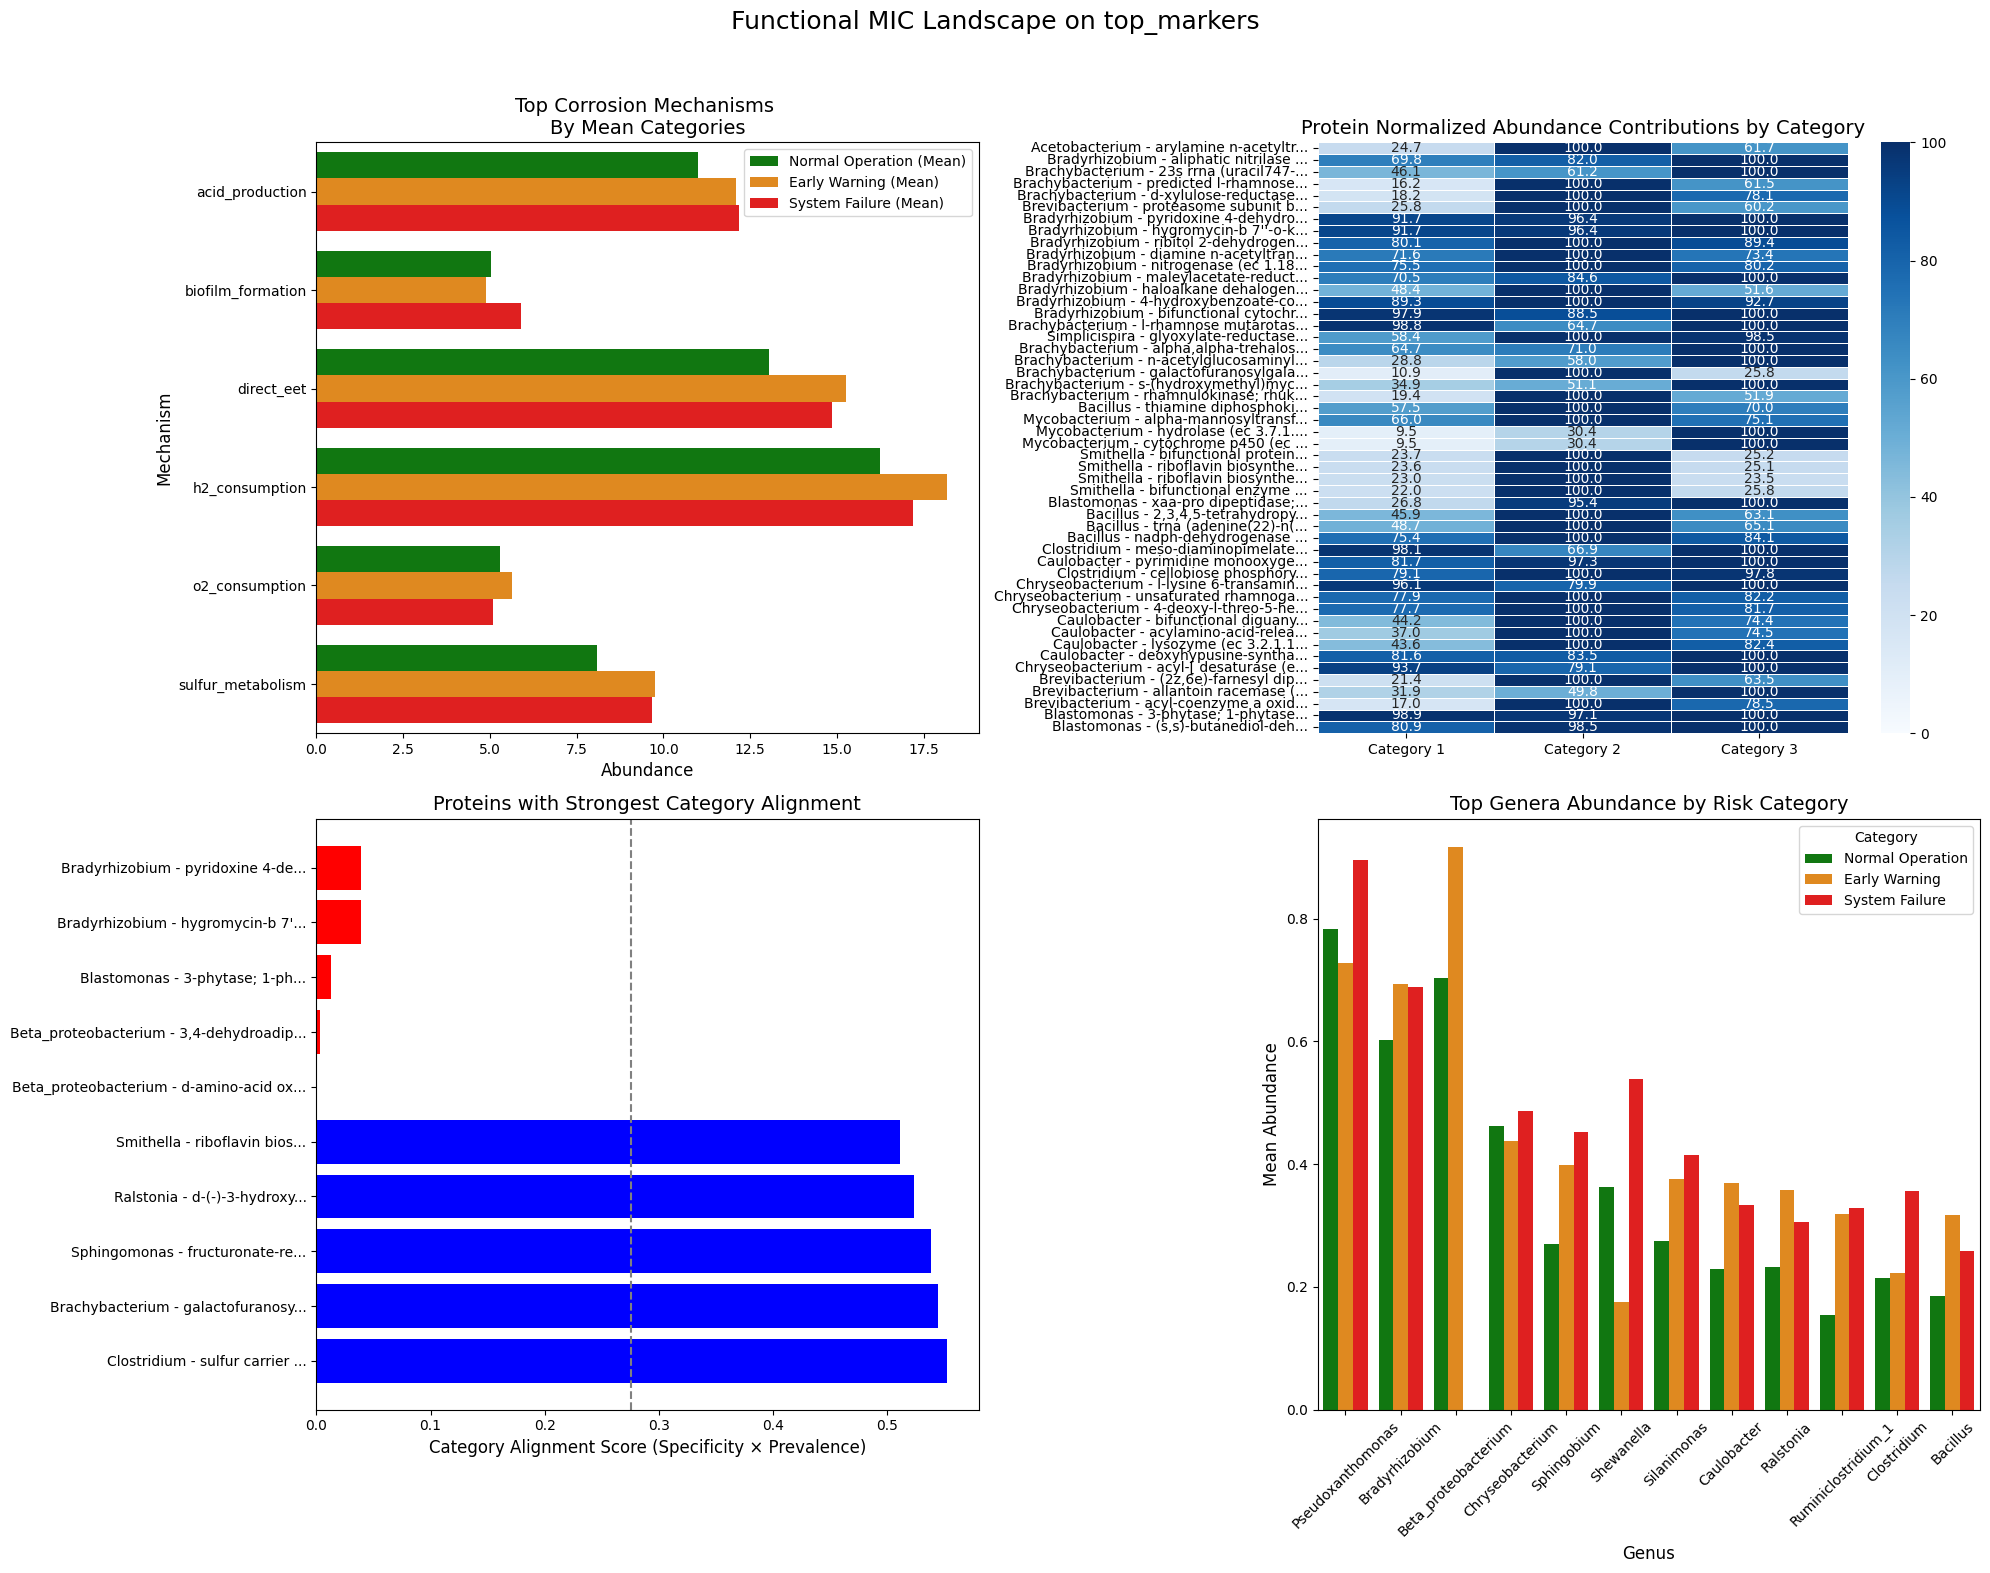

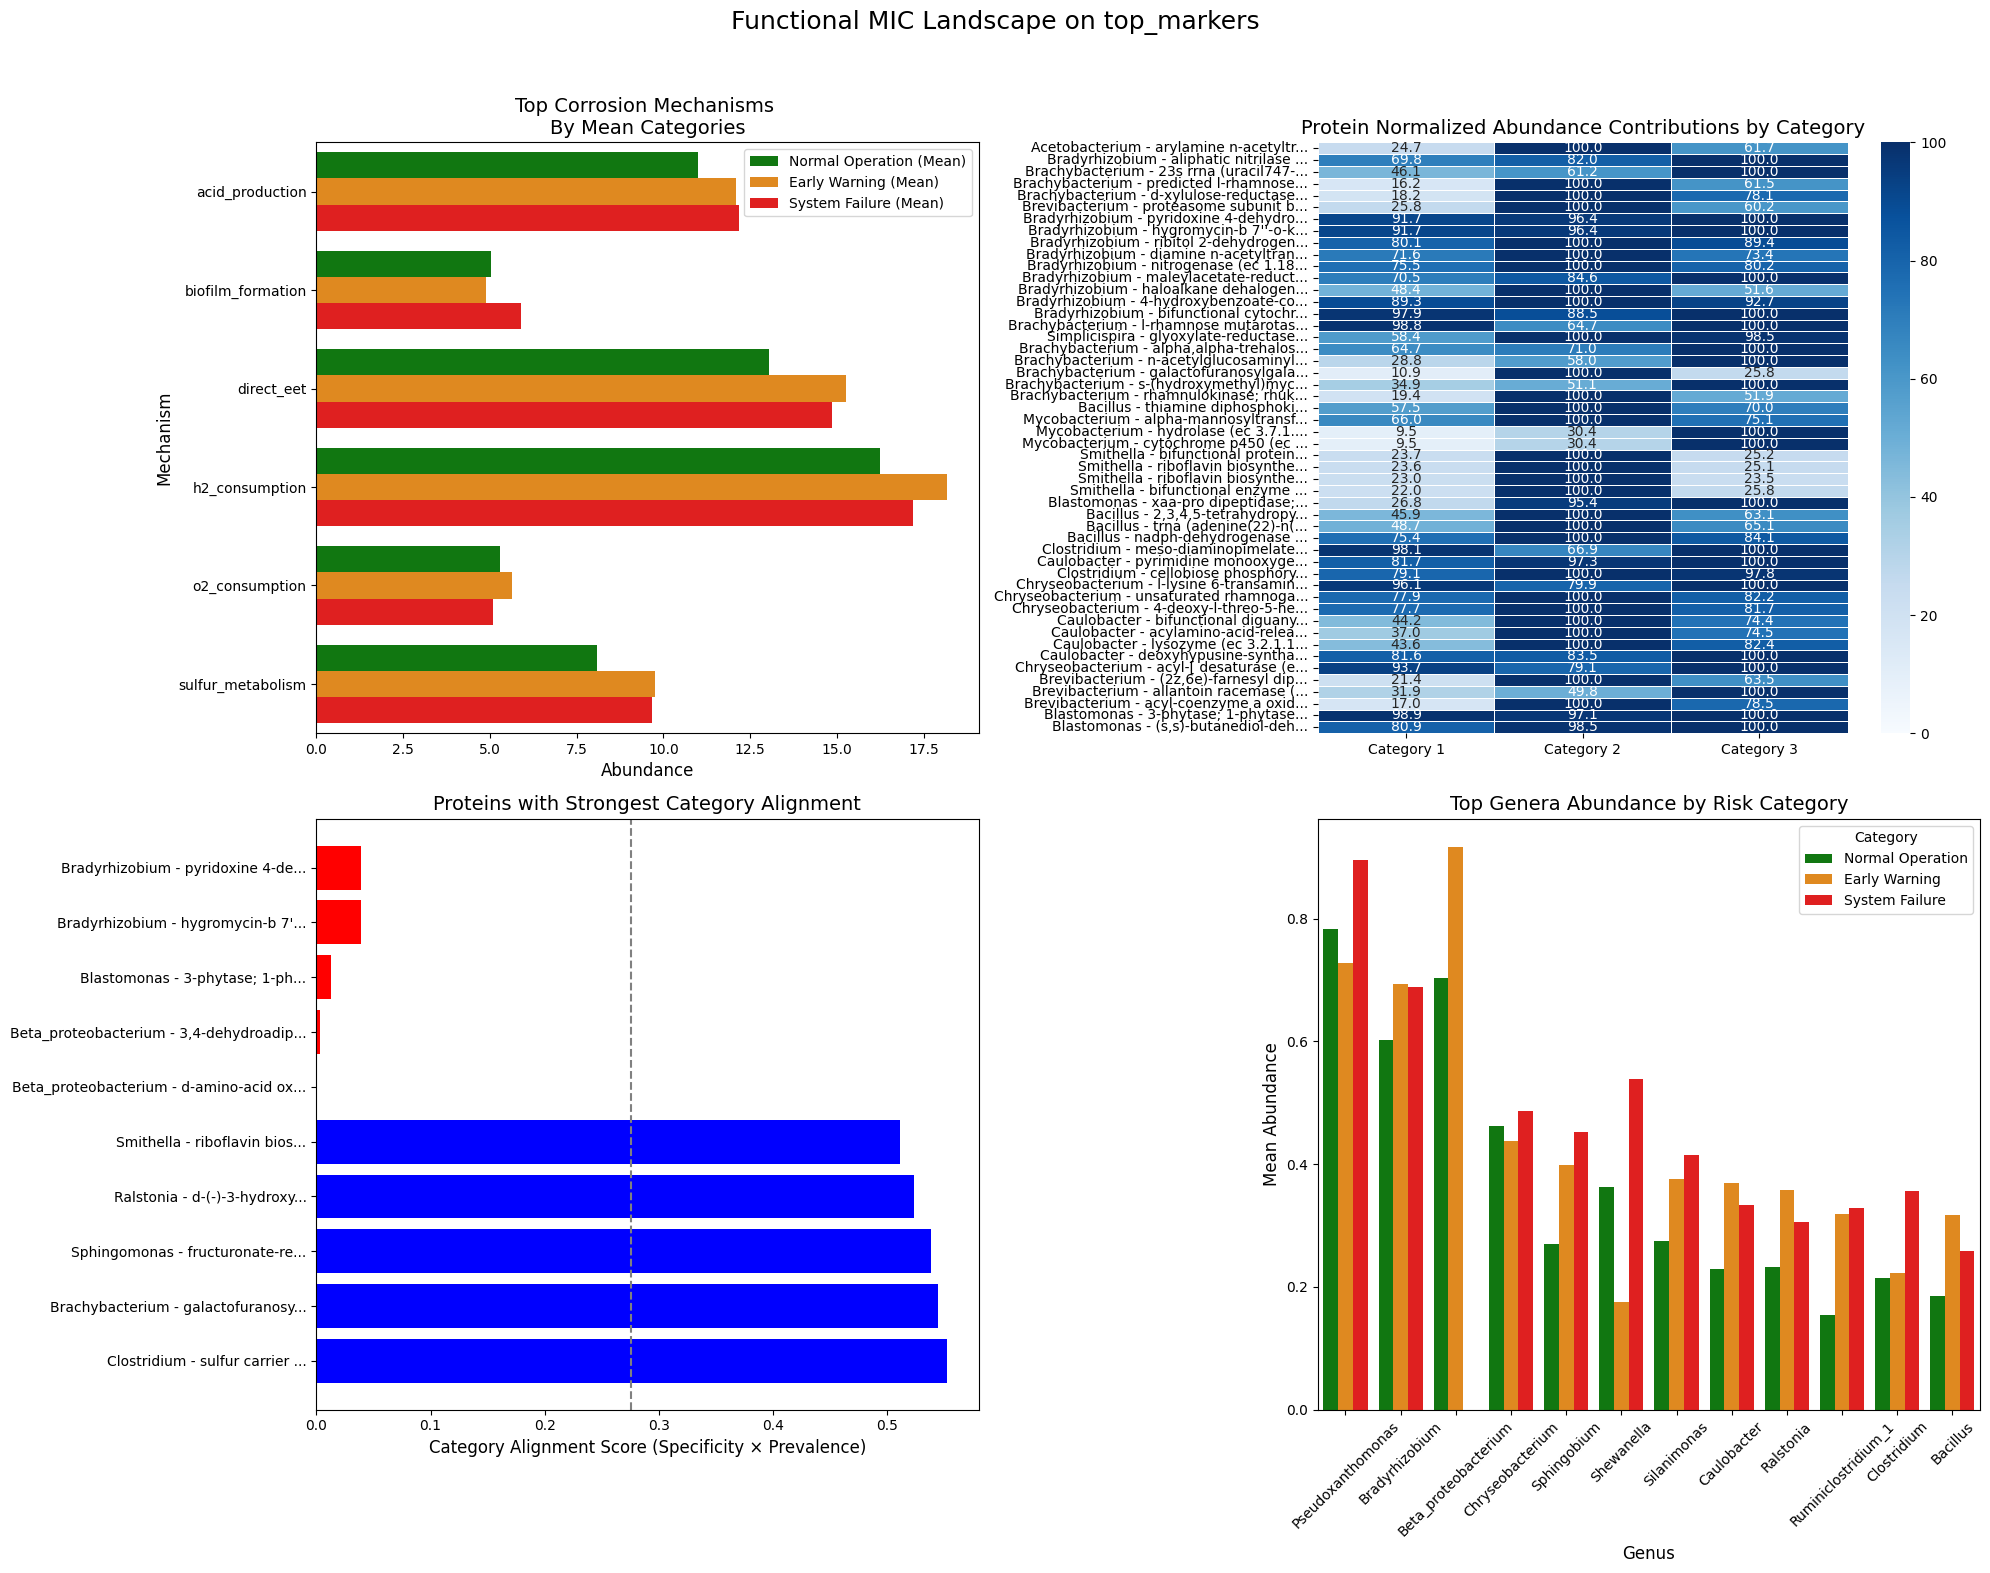

In [20]:
plot_multiview_functional_landscape(top_markers, "top_markers", top_n=150)

/tmp/ipykernel_3456/2709359639.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0)


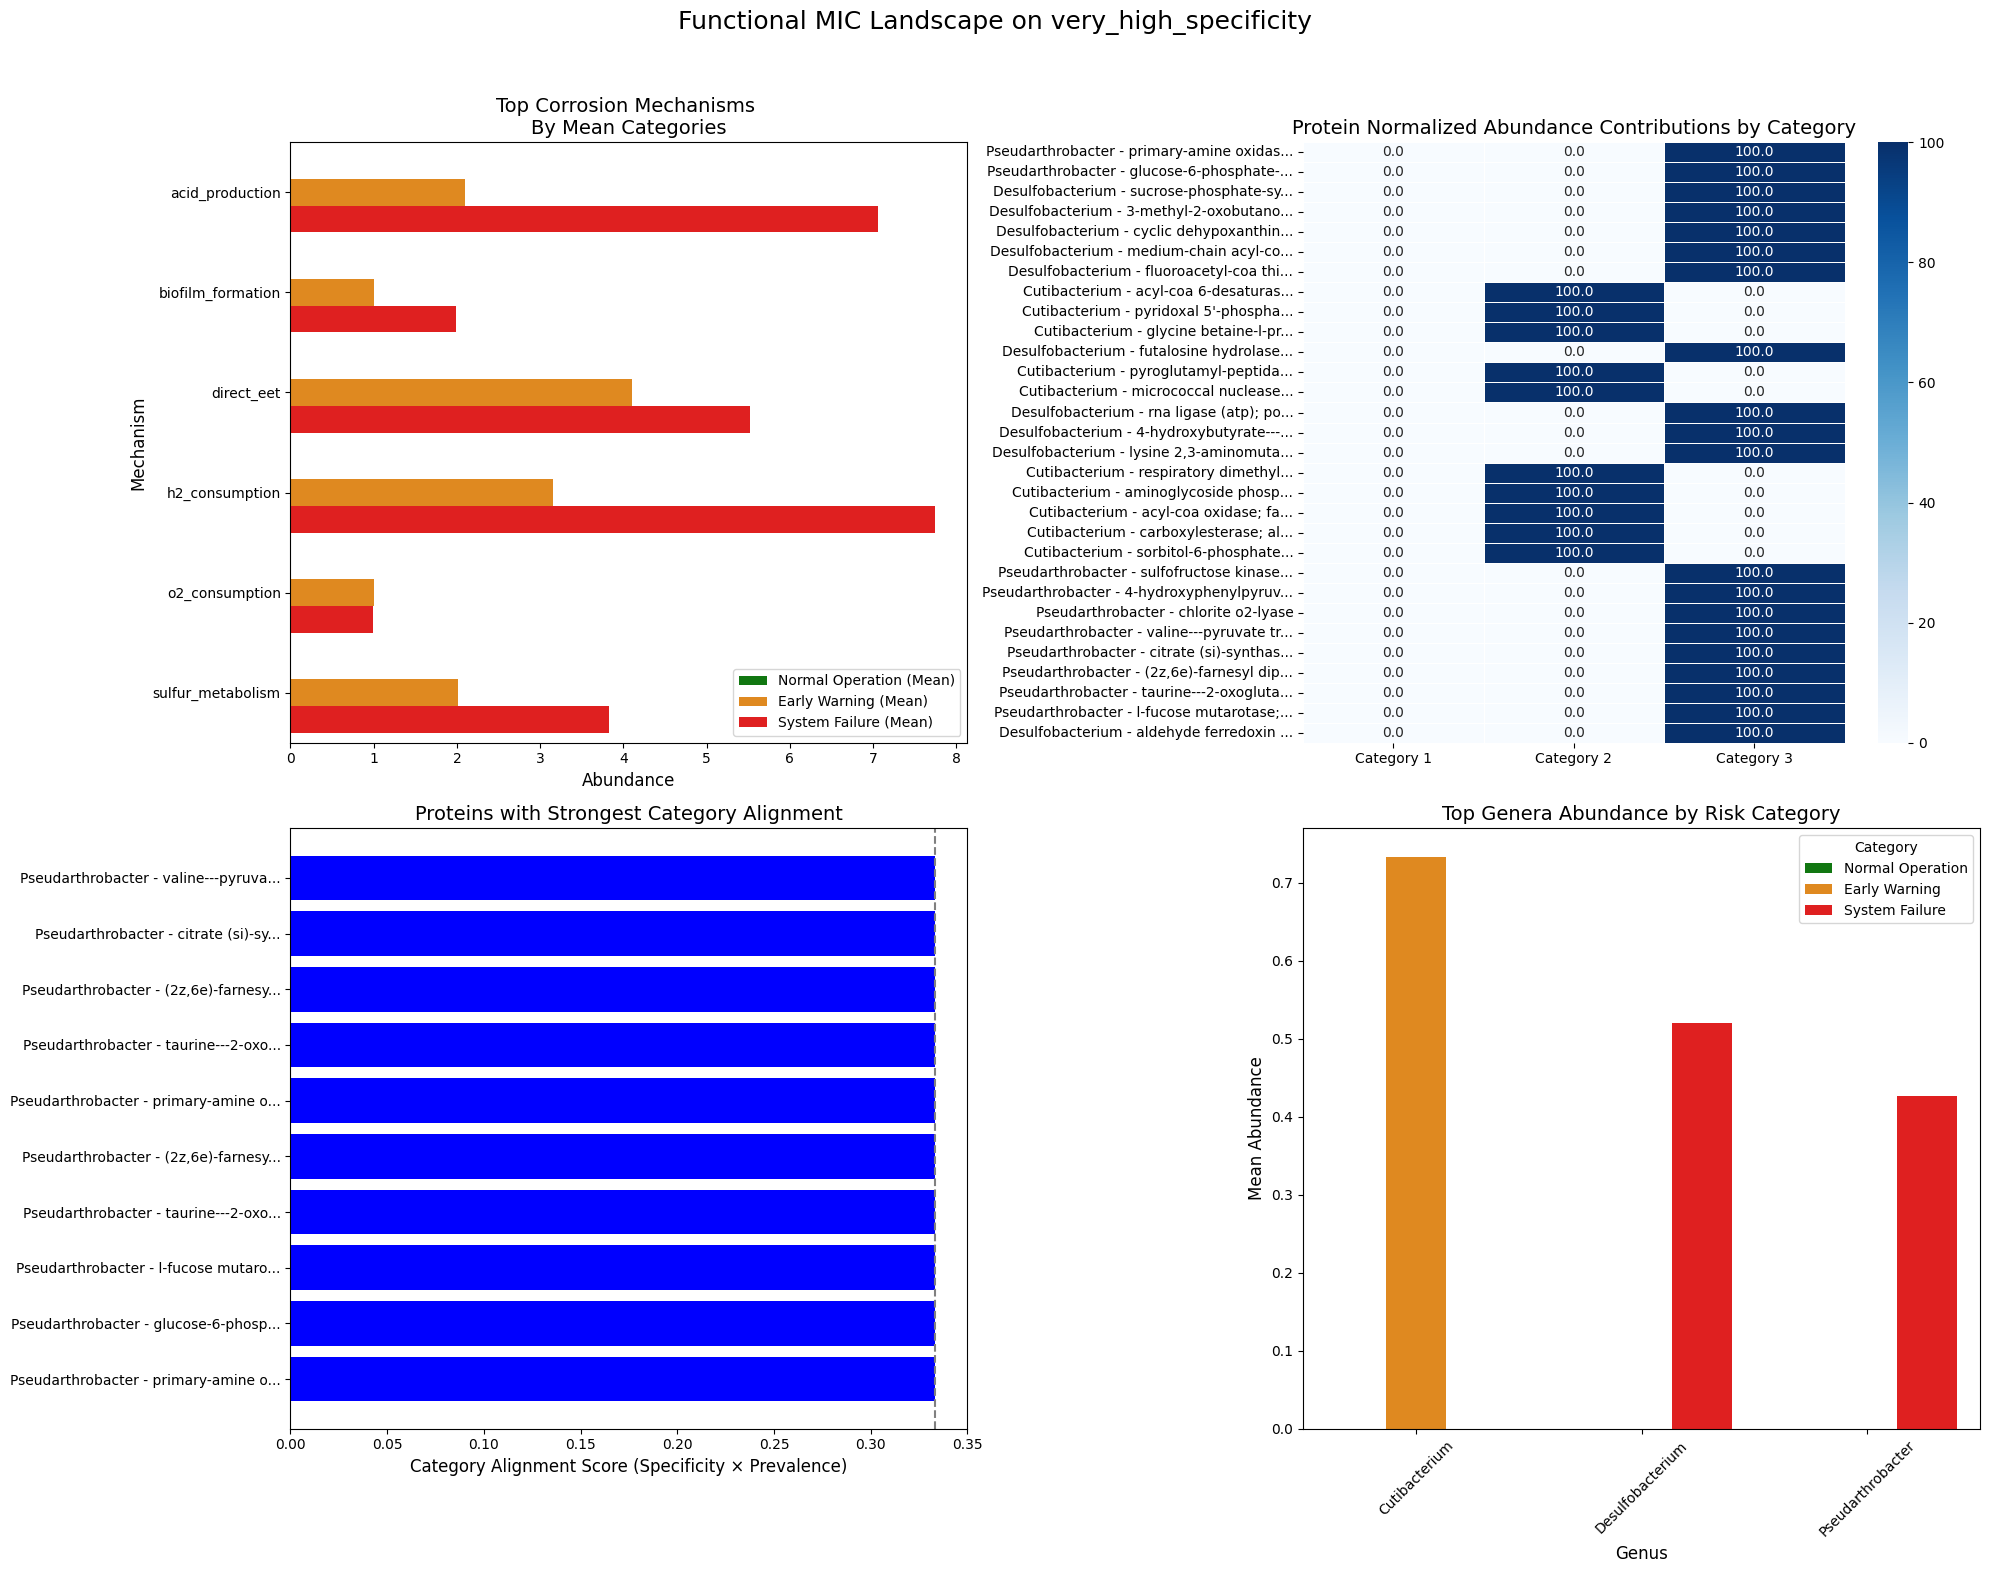

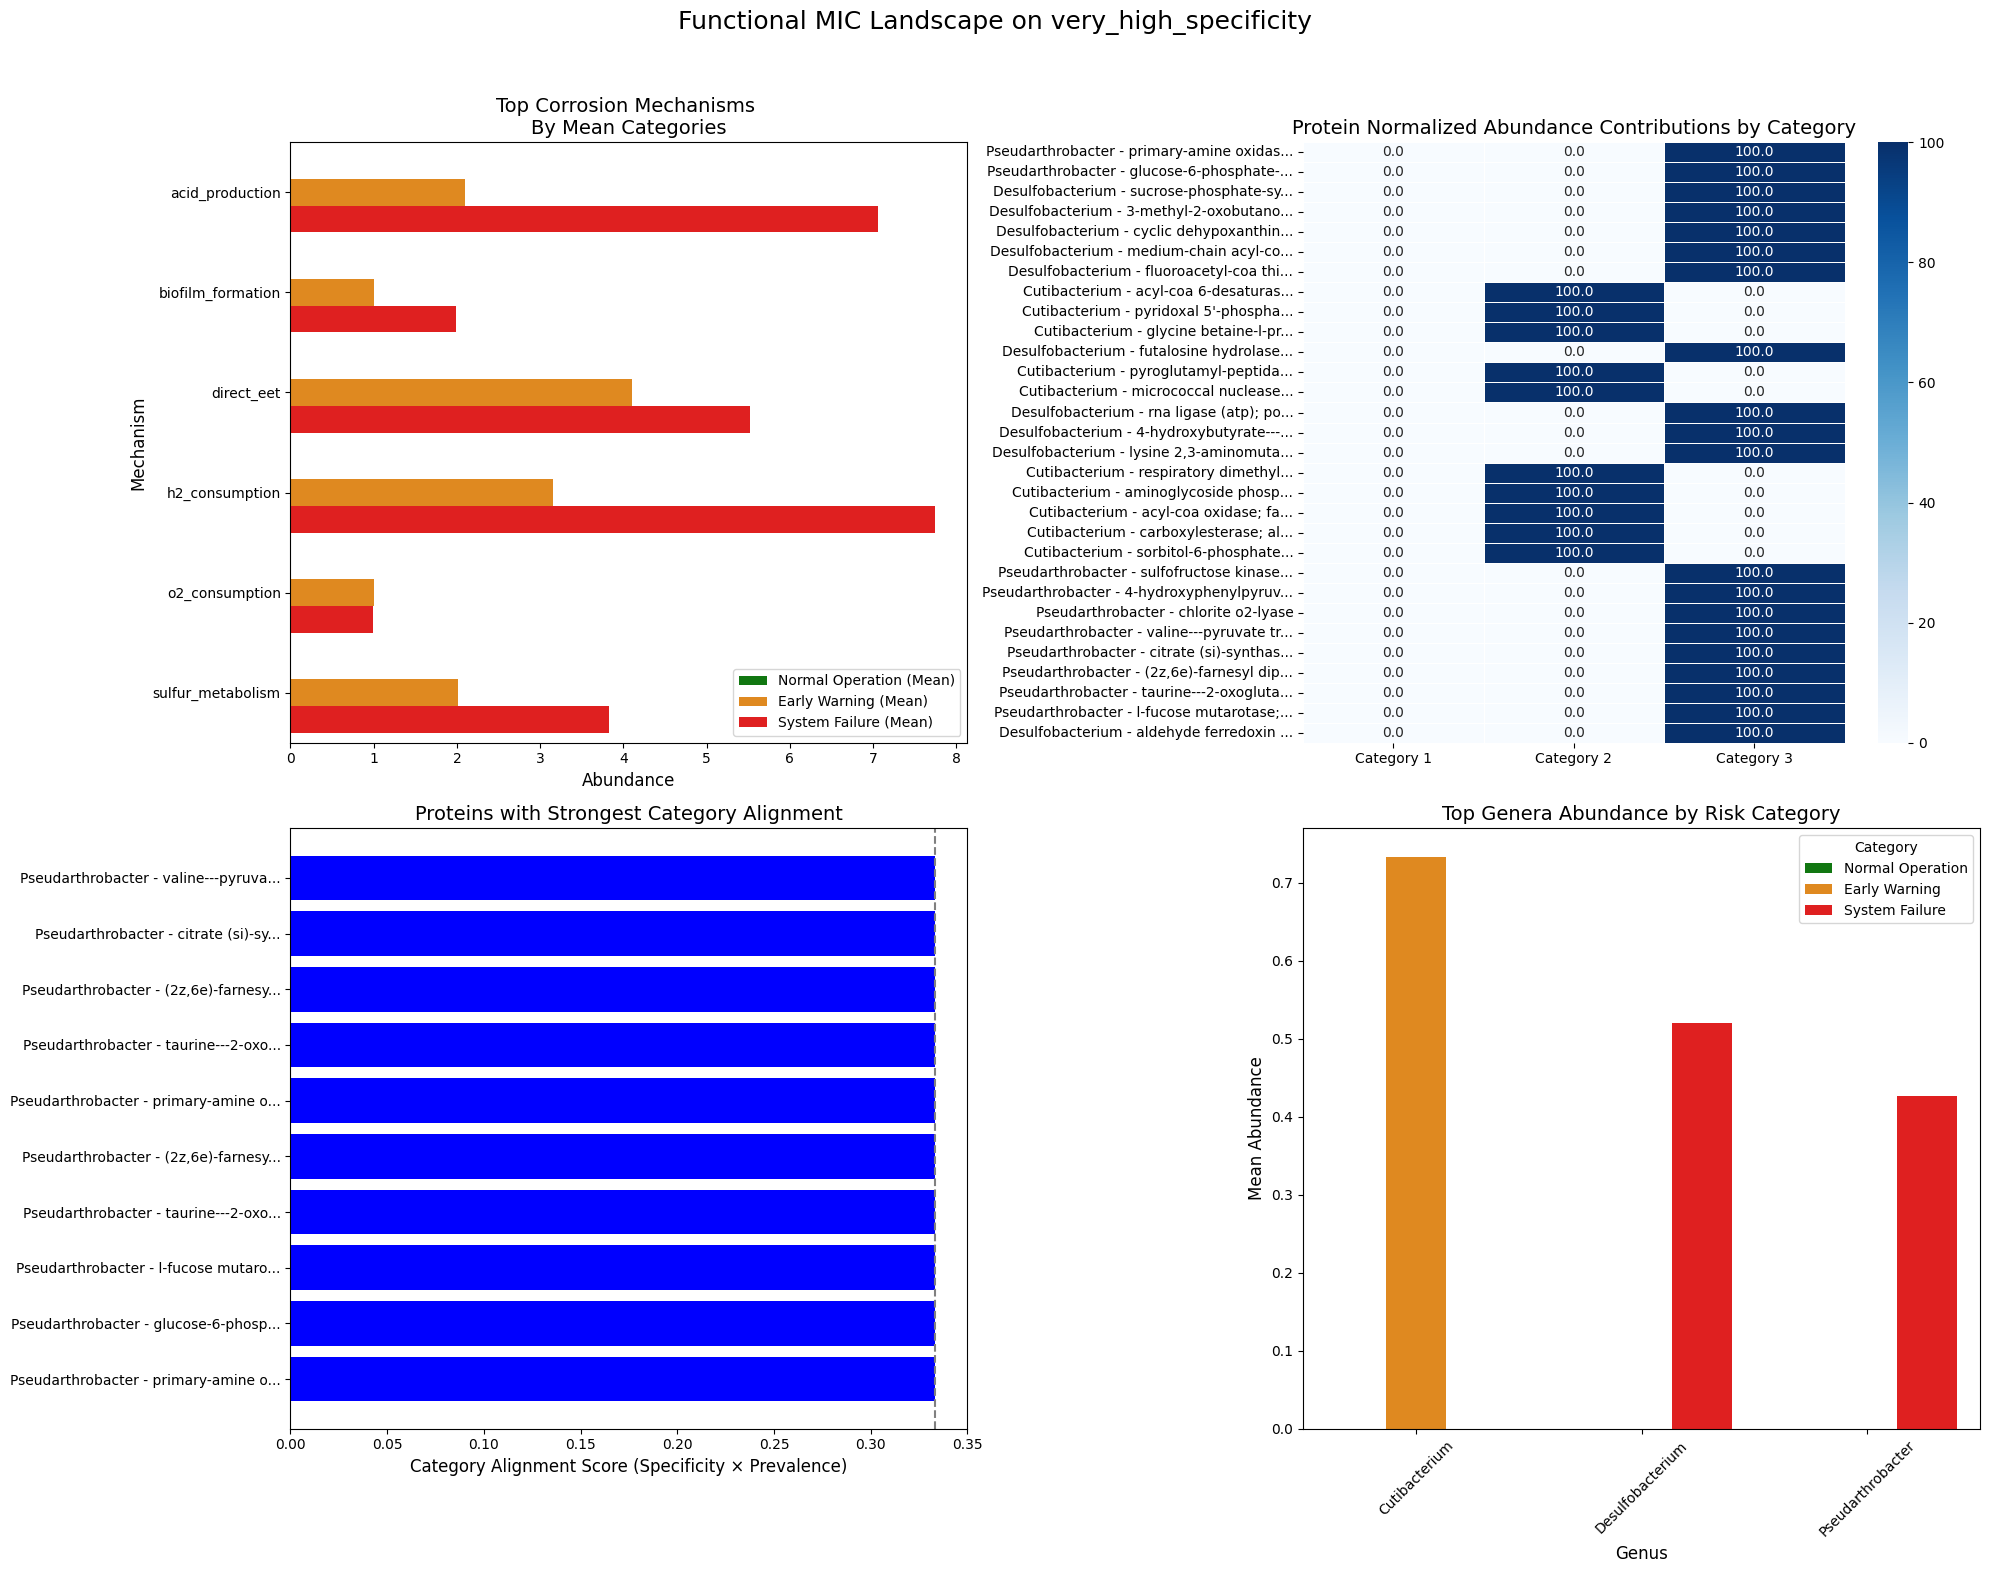

In [22]:
plot_multiview_functional_landscape(very_high_specificity,"very_high_specificity", top_n=100)

The prominence of acid production, direct eet, H2 consumption and sulphate production is expected on the the top mechanism at the granular level gives good consistency to the filtering pipeline. The plot for very_high_specificity group shows that the H2 consumption mechanism and the acid production predominate for that group.

## 3.2. Comparison of Mechanism by Category methodology

In [23]:
def corrosion_mechanism_original_vs_mean(top_markers, name="Comparison", top_n=10):
    """
    Create a comparison plot showing corrosion mechanisms using:
    1. Original Category (left subplot)
    2. Mean categories (right subplot)
    
    Parameters:
    -----------
    top_markers : DataFrame
        DataFrame containing the data with columns: 
        Category, corrosion_mechanisms, norm_abund_contri, mean_cat1, mean_cat2, mean_cat3
    name : str, optional
        Name to include in the plot title, by default "Comparison"
    top_n : int, optional
        Number of top mechanisms to display, by default 10
    save_path : str, optional
        Path to save the output figure, by default None
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure
    """
    # Define colors and categories for original Category
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    
    # Define colors for mean categories
    mean_colors = {
        'mean_cat1': '#008800',  # Dark green
        'mean_cat2': '#FF8C00',  # Dark orange
        'mean_cat3': '#FF0000'   # Red
    }
    
    # Mean category labels for the legend
    mean_labels = {
        'mean_cat1': 'Normal Operation (Mean)',
        'mean_cat2': 'Early Warning (Mean)',
        'mean_cat3': 'System Failure (Mean)'
    }
    
    # Select top markers by score
    top_markers = top_markers.copy(deep=False)
    
    # Ensure Category is integer type to prevent mapping issues
    top_markers['Category'] = top_markers['Category'].astype(int)
    
    # Create figure with multiple subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # 1. FIRST PLOT: Original Category (left)
    mech_by_category = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    mech_by_category.append({
                        'Mechanism': mech,
                        'Category': int(row['Category']),  # Ensure integer type
                        'norm_abund_contri': row['norm_abund_contri']
                    })
    
    # Convert to DataFrame and aggregate
    mech_df = pd.DataFrame(mech_by_category)
    
    # Check if we have mechanisms data to plot
    if not mech_df.empty:
        # Group by mechanism and original category, summing abundance
        agg_mech = mech_df.groupby(['Mechanism', 'Category'])['norm_abund_contri'].sum().reset_index(name='Abundance')
        
        # Sort by abundance and get top mechanisms
        top_mechanisms = agg_mech.groupby('Mechanism')['Abundance'].sum().nlargest(top_n).index
        agg_mech = agg_mech[agg_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with consistent category colors
        sns.barplot(
            data=agg_mech,
            x='Abundance',
            y='Mechanism',
            hue='Category',
            palette=category_colors,
            ax=ax1
        )
        
        # Ensure legend shows categories with proper labels
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles, labels=[categories_labels[int(label)] for label in labels])
        ax1.set_title(f"Top Corrosion Mechanisms - {name}\nBy Original Category", fontsize=14)
        ax1.set_xlabel('Abundance', fontsize=12)
        ax1.set_ylabel('Mechanism', fontsize=14)
    else:
        ax1.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax1.set_title('Top Corrosion Mechanisms by Original Category', fontsize=14)
    
    # 2. SECOND PLOT: Mean categories (right)
    mech_by_mean = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            # Get mean values
            mean_cat1 = row.get('mean_cat1', 0)
            mean_cat2 = row.get('mean_cat2', 0)
            mean_cat3 = row.get('mean_cat3', 0)
            
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    # Add entry for each category with its corresponding mean value
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat1',
                        'Abundance': mean_cat1 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat2',
                        'Abundance': mean_cat2 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat3',
                        'Abundance': mean_cat3 * row['norm_abund_contri']
                    })
    
    # Convert to DataFrame for mean categories
    mean_mech_df = pd.DataFrame(mech_by_mean)
    
    # Second plot - mean categories
    if not mean_mech_df.empty:
        # Use the same top mechanisms as in the first plot for consistency
        # Aggregate by mechanism and mean category
        agg_mean_mech = mean_mech_df.groupby(['Mechanism', 'Mean_Category'])['Abundance'].sum().reset_index()
        
        # Filter to the same top mechanisms from the first plot for consistency
        agg_mean_mech = agg_mean_mech[agg_mean_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with mean category colors
        sns.barplot(
            data=agg_mean_mech,
            x='Abundance',
            y='Mechanism',
            hue='Mean_Category',
            palette=mean_colors,
            ax=ax2
        )
        
        # Update legend with readable mean category labels
        handles, labels = ax2.get_legend_handles_labels()
        ax2.legend(handles=handles, labels=[mean_labels[label] for label in labels])
        
        ax2.set_title(f"Top Corrosion Mechanisms - {name}\nBy Mean Categories", fontsize=14)
        ax2.set_xlabel('Abundance', fontsize=14)
        ax2.set_ylabel('', fontsize=14)  
    else:
        ax2.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax2.set_title('Top Corrosion Mechanisms by Mean Categories', fontsize=14)
    
    plt.tight_layout(pad=2)
    
    return fig


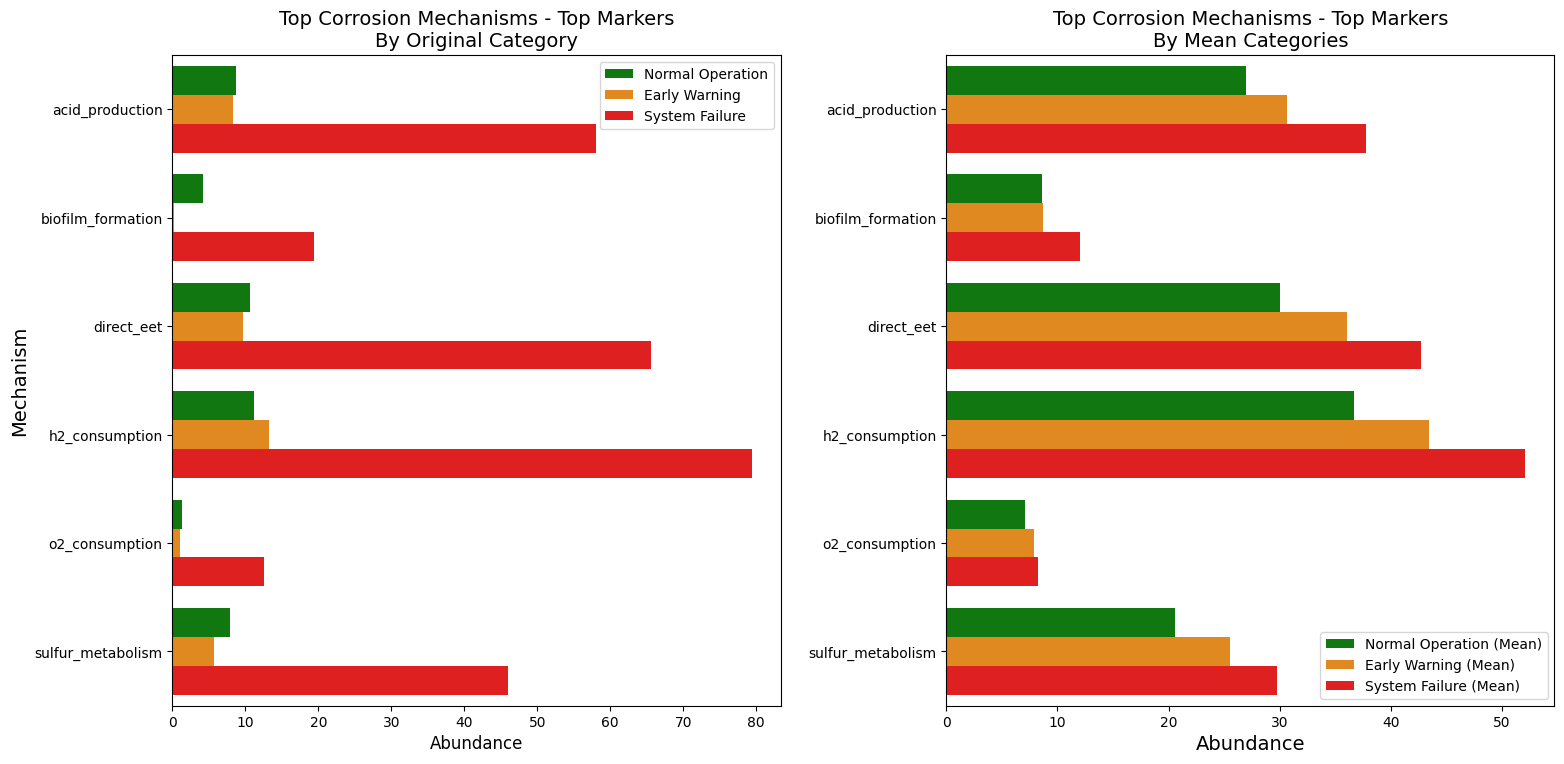

In [24]:
#Calling the function:
fig = corrosion_mechanism_original_vs_mean(top_markers, "Top Markers",  top_n=50)
plt.show()

The use of the original column of category and the mean shows that the mean actually try to homogenise the data on a way, however the main metabolisms remain to be the same first the H2 consumption , followed by direct electron transference, acid production and sulfur metabolism on top markers. 

## 3.3 Pathway Data across Risk Categories

### MultiPathway Analysis

In [ ]:
def extract_pathways(df, pathway_column='pathways'):
    """Extract and count unique pathways from a DataFrame."""
    all_pathways = []

    for pathways in df[pathway_column].dropna():
        if isinstance(pathways, str):
            # Split by semicolons and clean up each pathway
            pathway_list = [p.strip() for p in pathways.split(';')]
            all_pathways.extend(pathway_list)

    # Count occurrences of each pathway
    pathway_counts = pd.Series(all_pathways).value_counts()

    return pathway_counts

def categorize_pathway(pathway):
    """Categorize pathway into broader functional categories."""
    pathway = pathway.lower()

    if any(term in pathway for term in ['metal', 'iron', 'copper', 'nickel', 'zinc']):
        return 'Metal Metabolism'
    elif any(term in pathway for term in ['sulfur', 'sulfate', 'sulfide']):
        return 'Sulfur Metabolism'
    elif any(term in pathway for term in ['nitrogen', 'nitrate', 'nitrite', 'ammonia']):
        return 'Nitrogen Metabolism'
    elif any(term in pathway for term in ['biofilm', 'quorum', 'adhesion']):
        return 'Biofilm Formation'
    elif any(term in pathway for term in ['oxidation', 'reduction', 'electron transport']):
        return 'Redox Processes'
    elif any(term in pathway for term in ['acid', 'acidic']):
        return 'Acid Production'
    elif any(term in pathway for term in ['exopolysaccharide', 'polysaccharide', 'eps']):
        return 'EPS Production'
    elif any(term in pathway for term in ['stress', 'resistance', 'tolerance']):
        return 'Stress Response'
    elif any(term in pathway for term in ['carbon', 'c-compound']):
        return 'Carbon Metabolism'
    elif any(term in pathway for term in ['amino acid', 'protein']):
        return 'Protein/Amino Acid Metabolism'
    elif any(term in pathway for term in ['lipid', 'fatty acid']):
        return 'Lipid Metabolism'
    elif any(term in pathway for term in ['transport']):
        return 'Transport'
    elif any(term in pathway for term in ['energy', 'atp']):
        return 'Energy Metabolism'
    elif any(term in pathway for term in ['degrade', 'degradation']):
        return 'Degradation Pathways'
    elif any(term in pathway for term in ['synthesis', 'biosynthesis']):
        return 'Biosynthesis Pathways'
    elif any(term in pathway for term in ['fermentation']):
        return 'Fermentation'
    elif any(term in pathway for term in ['respiration']):
        return 'Respiratory Pathways'
    elif any(term in pathway for term in ['metabolism']):
        return 'General Metabolism'
    else:
        return 'Other Metabolic Processes'
def plot_pathway_analysis(prioritized_markers, name, top_n=100):
    """
    Creates comprehensive visualizations of pathway data across risk categories.
    """
    plt.close('all')
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)
    pathway_counts = extract_pathways(top_markers)
    common_pathways = pathway_counts[pathway_counts >= 2].index.tolist()
    pathway_categories = {}
    for pathway in common_pathways:
        category = categorize_pathway(pathway)
        pathway_categories[category] = pathway_categories.get(category, 0) + pathway_counts[pathway]
    category_df = pd.DataFrame({'Category': list(pathway_categories.keys()), 'Count': list(pathway_categories.values())}).sort_values('Count', ascending=False)
    pathway_data = []
    for _, row in top_markers.iterrows():
        if isinstance(row['pathways'], str) and row['pathways']:
            row_pathways = [p.strip() for p in row['pathways'].split(';')]
            for pathway in row_pathways:
                if pathway in common_pathways:
                    pathway_data.append({
                        'Pathway': pathway,
                        'Category': categorize_pathway(pathway),
                        'Category 1': row['mean_cat1'] if pd.notna(row['mean_cat1']) else 0,
                        'Category 2': row['mean_cat2'] if pd.notna(row['mean_cat2']) else 0,
                        'Category 3': row['mean_cat3'] if pd.notna(row['mean_cat3']) else 0,
                    })
    pathway_df = pd.DataFrame(pathway_data)
    agg_pathway = pathway_df.groupby('Category').agg({'Category 1': 'mean', 'Category 2': 'mean', 'Category 3': 'mean'}).reset_index()
    agg_pathway['Cat3_to_Cat1_Ratio'] = agg_pathway.apply(lambda x: x['Category 3'] / x['Category 1'] if x['Category 1'] > 0 else (10 if x['Category 3'] > 0 else 1), axis=1)
    agg_pathway = agg_pathway.sort_values('Cat3_to_Cat1_Ratio', ascending=False)
    fig, axes = plt.subplots(2, 2, figsize=(18, 14)) #Create a 2x2 grid.
    sns.barplot(data=category_df, x='Count', y='Category', color='skyblue', ax=axes[0, 0])
    for i, bar in enumerate(axes[0, 0].patches):
        axes[0, 0].text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2, f"{int(bar.get_width())}", ha='left', va='center', fontsize=12)
    axes[0, 0].set_title('Distribution of Pathway Categories', fontsize=18)
    axes[0, 0].tick_params(axis='both', labelsize=14)
    G = nx.Graph()
    for category, count in pathway_categories.items():
        G.add_node(category, size=count, group=1)
    genera_counts = top_markers['Genus'].value_counts().head(10)
    for genus, count in genera_counts.items():
        G.add_node(genus, size=count * 3, group=2)
    for _, row in top_markers.iterrows():
        genus = row['Genus']
        if genus not in genera_counts:
            continue
        if isinstance(row['pathways'], str) and row['pathways']:
            pathways = [p.strip() for p in row['pathways'].split(';')]
            categories_added = set()
            for pathway in pathways:
                if pathway in common_pathways:
                    category = categorize_pathway(pathway)
                    if category not in categories_added:
                        if not G.has_edge(genus, category):
                            G.add_edge(genus, category, weight=1)
                        else:
                            G[genus][category]['weight'] += 1
                        categories_added.add(category)
    pos = nx.spring_layout(G, k=0.3, seed=42)
    category_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 1]
    genera_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 2]
    node_sizes_cat = [G.nodes[node].get('size', 10) * 20 for node in category_nodes]
    node_sizes_gen = [G.nodes[node].get('size', 10) * 20 for node in genera_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color='lightblue', node_size=node_sizes_cat, alpha=0.8, ax=axes[1, 1])
    nx.draw_networkx_nodes(G, pos, nodelist=genera_nodes, node_color='lightgreen', node_size=node_sizes_gen, alpha=0.8, ax=axes[1, 1])
    edge_weights = [G[u][v].get('weight', 1) / 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, ax=axes[1, 1])
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', ax=axes[1, 1])
    axes[1, 1].set_title('Genus-Pathway Category Network', fontsize=18)
    axes[1, 1].axis('off') #Turn off the axis.
    sns.barplot(data=agg_pathway, x='Cat3_to_Cat1_Ratio', y='Category', color='steelblue', ax=axes[1, 0])
    for i, bar in enumerate(axes[1, 0].patches):
        ratio_value = agg_pathway.iloc[i]['Cat3_to_Cat1_Ratio']
        axes[1, 0].text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, f"{ratio_value:.2f}x", ha='left', va='center', fontsize=12)
    axes[1, 0].axvline(x=1, color='gray', linestyle='--')
    axes[1, 0].set_title('Pathway Category Enrichment in High Risk (Cat3:Cat1 Ratio)', fontsize=18)
    axes[1, 0].tick_params(axis='both', labelsize=14)
    heatmap_data = agg_pathway.set_index('Category')[['Category 1', 'Category 2', 'Category 3']].fillna(0)
    for idx in heatmap_data.index:
        row_max = heatmap_data.loc[idx].max()
        if row_max > 0:
            heatmap_data.loc[idx] = (heatmap_data.loc[idx] / row_max * 100).round(1)
    sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt=".1f", linewidths=0.5, ax=axes[0, 1], vmin=0, vmax=100, annot_kws={"size": 12}) #put the heatmap on the 2nd position.
    axes[0, 1].set_title('Pathway Category Abundance Patterns (% of max)', fontsize=18)
    axes[0, 1].tick_params(axis='both', labelsize=14)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # Overall title
    plt.suptitle(f"Pathways Categories for {name}", fontsize=18, y=0.98)
    return fig, category_df, agg_pathway

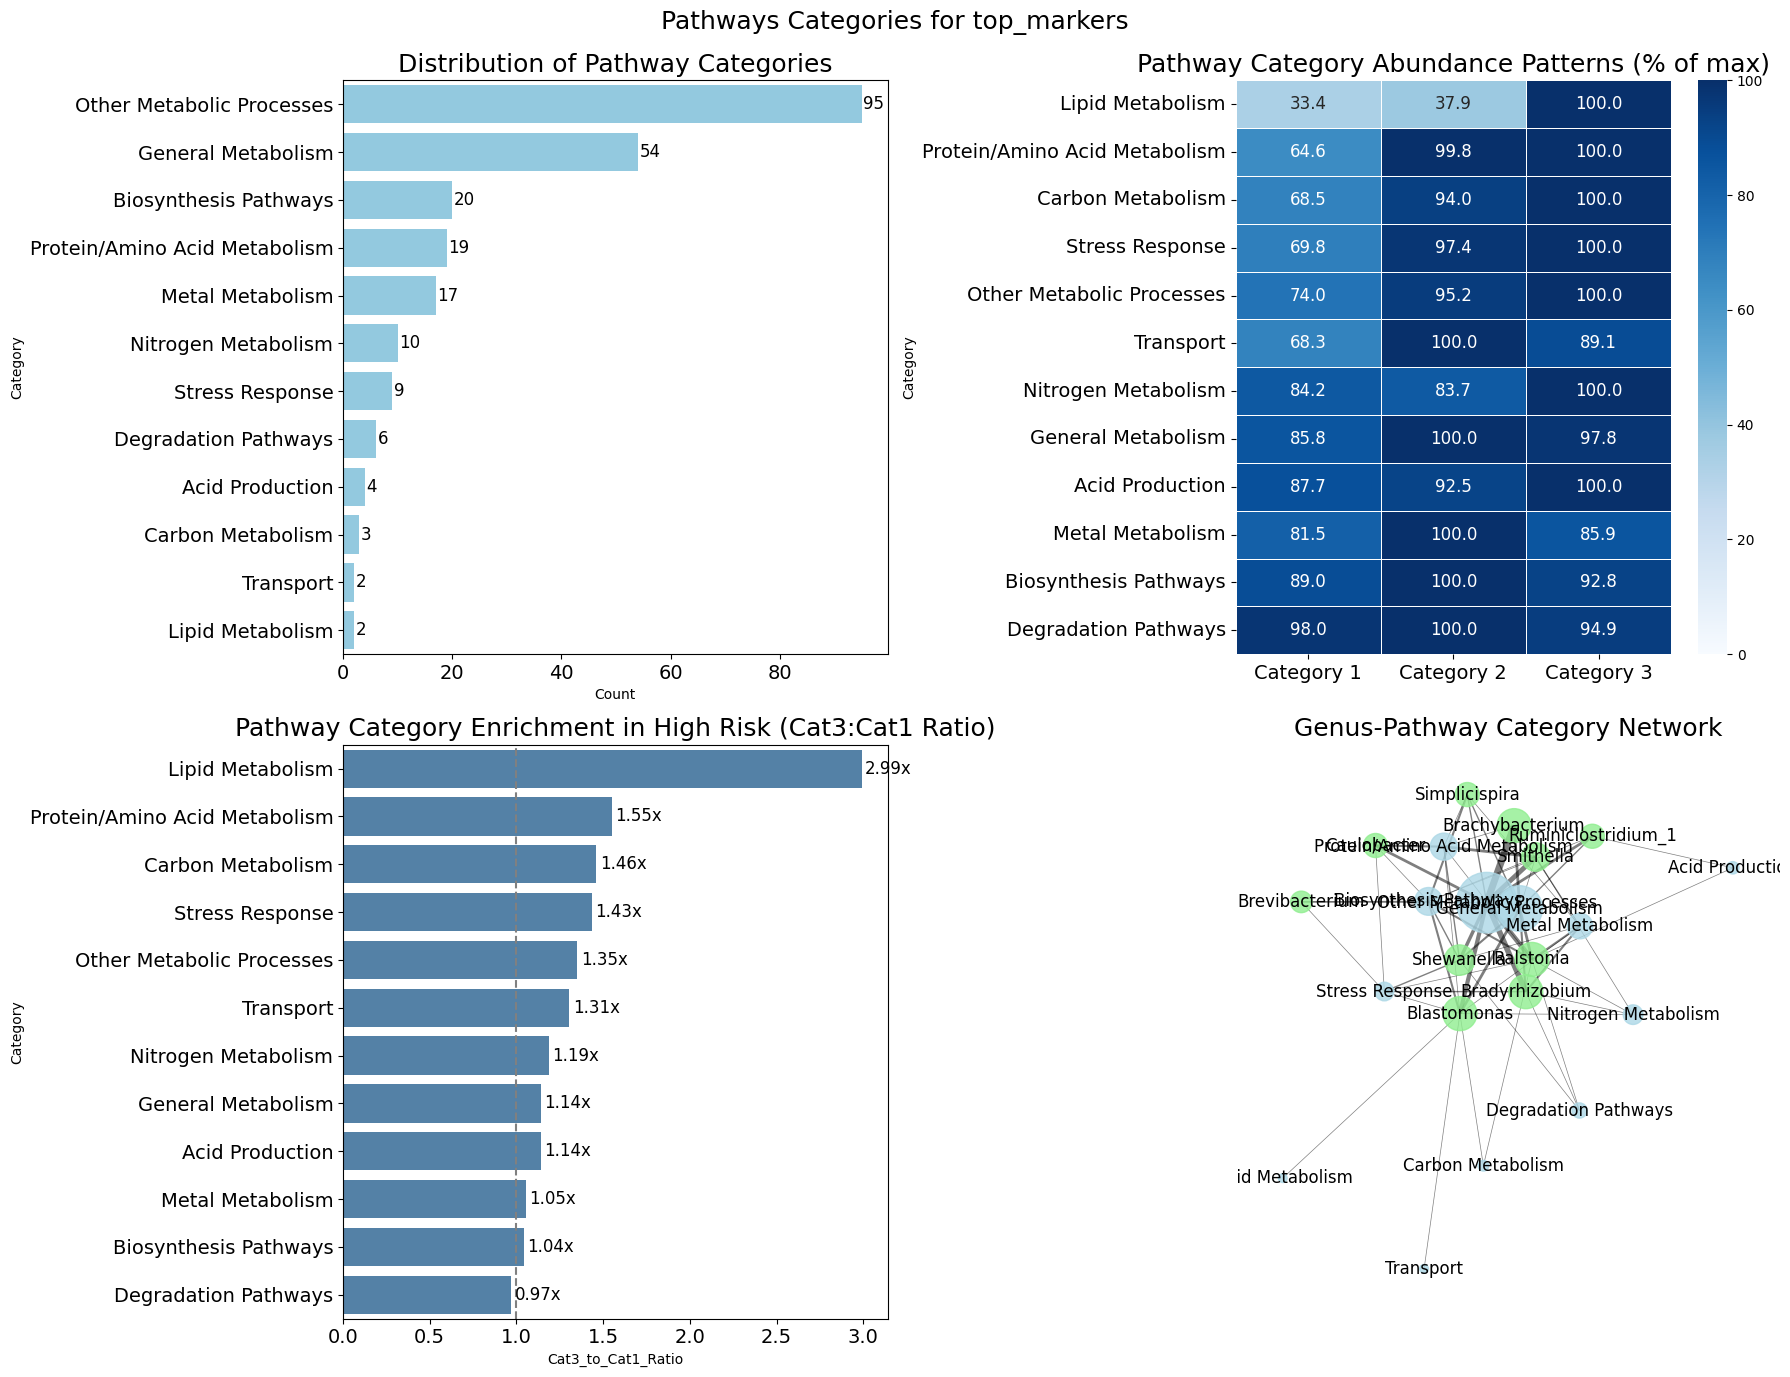

In [39]:
fig = plot_pathway_analysis(top_markers, "top_markers", top_n=100)
plt.show()

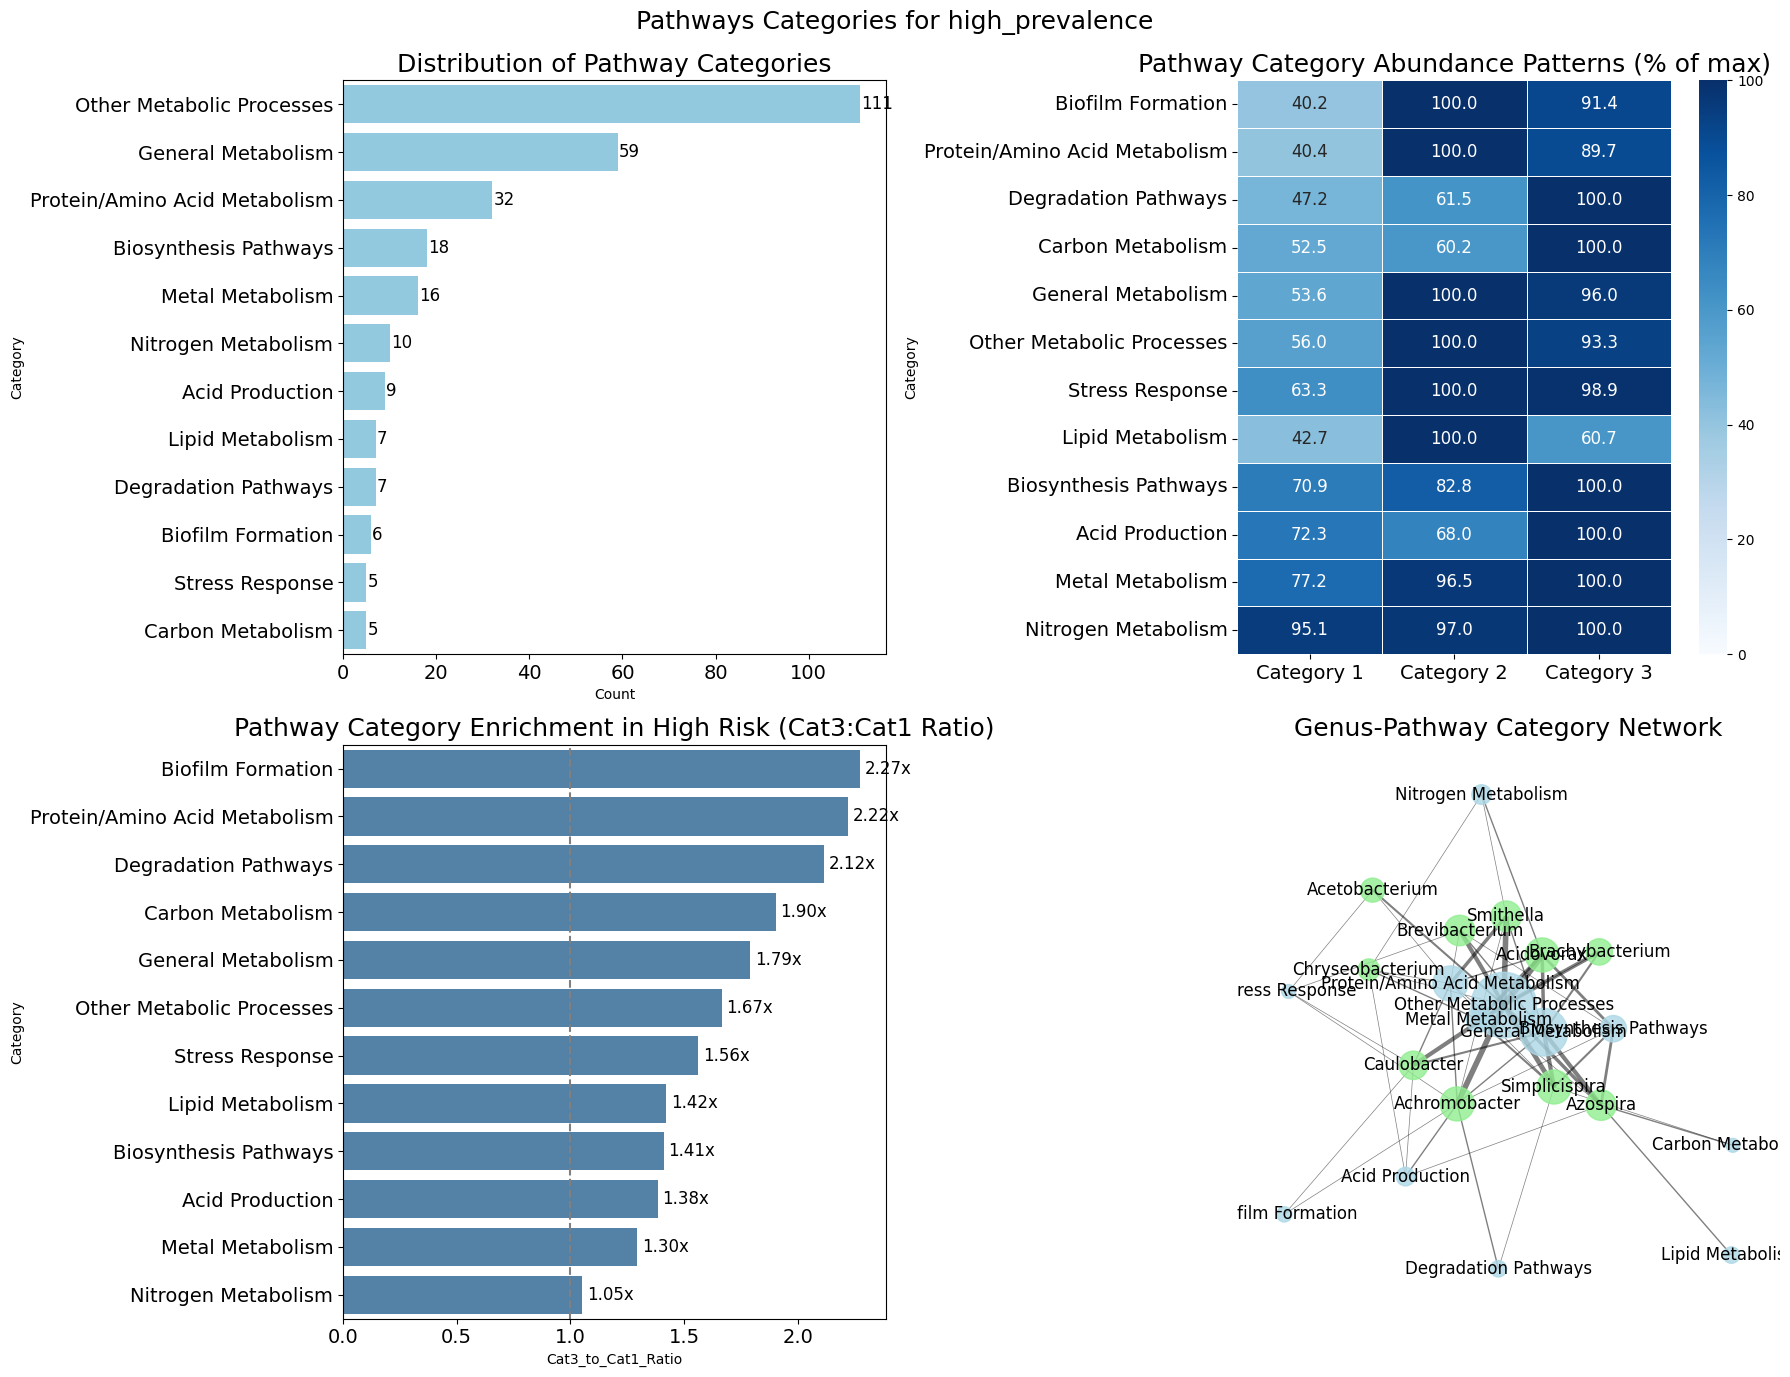

In [40]:
fig = plot_pathway_analysis(high_prevalence,"high_prevalence", top_n=100)
plt.show()


For the top markers group, the dominance of lipid metabolism is interesting...
for the high prevalence has the genera that prevale on each category, so the major metabolism is the biofilm formation which is also the one when it get enrich, that is because the biofilm produce an specialise environment where the bacteria thrive and prevail. It follows the protein metabolism with is important for survival, the degradation pathway which involves using the substrates from the env

## 3.4 Network Analysis of Corrosion Mechanisms

### Static Network

In [47]:
def create_static_network(df, name, top_n=20, threshold=0.5):
    """
    Creates a static network visualization of genus-protein-mechanism relationships.

    Args:
        df: DataFrame containing marker data with required columns
        top_n: Number of top markers to include
        threshold: Edge weight threshold (0.0-1.0)

    Returns:
        G: NetworkX graph object
    """

    # Define colors for node types
    node_colors = {
        'genus': '#2196F3',      # Blue
        'protein': '#4CAF50',    # Green
        'mechanism': '#FF5722'   # Orange-red
    }

    # Check required columns
    required_cols = ['Genus', 'protein_name', 'combined_score', 'corrosion_mechanisms']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        print("Available columns:", df.columns.tolist())
        return None

    # Create network
    G = nx.Graph()

    # Get top markers
    top_markers = df.sort_values('combined_score', ascending=False).head(top_n)

    # Process rows and build network
    for _, row in top_markers.iterrows():
        genus = str(row['Genus'])
        protein = str(row['protein_name'])

        # Skip if missing data
        if pd.isna(genus) or pd.isna(protein):
            continue

        # Trim protein name if too long
        protein_short = protein[:27] + "..." if len(protein) > 30 else protein

        # Add nodes if they don't exist
        if not G.has_node(genus):
            G.add_node(genus, type='genus')

        if not G.has_node(protein_short):
            G.add_node(protein_short, type='protein')

        # Add edge between genus and protein with weight from score
        score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
        G.add_edge(genus, protein_short, weight=score)

        # Add mechanism nodes and edges
        mechanisms_col = row.get('corrosion_mechanisms', '')
        if isinstance(mechanisms_col, str) and mechanisms_col:
            for mech in mechanisms_col.split(';'):
                mech = mech.strip()
                if mech:  # Only add non-empty mechanisms
                    if not G.has_node(mech):
                        G.add_node(mech, type='mechanism')
                    G.add_edge(protein_short, mech, weight=1.0)

    # Detect communities
    partition = community_louvain.best_partition(G)

    # Assign communities to nodes
    nx.set_node_attributes(G, partition, 'community')

    # Prepare for visualization
    plt.figure(figsize=(15, 12))

    # Position nodes using force-directed layout
    pos = nx.spring_layout(G, k=0.3, seed=42)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    # Draw nodes by type with different colors
    for node_type, color in node_colors.items():
        nodes = [node for node in G.nodes() if G.nodes[node].get('type') == node_type]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color,
                              node_size=500 if node_type == 'genus' else 300)

    # Draw labels differently for each type
    genera_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'genus'}
    nx.draw_networkx_labels(G, pos, labels=genera_labels, font_size=10, font_weight='bold')

    mech_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'mechanism'}
    nx.draw_networkx_labels(G, pos, labels=mech_labels, font_size=8)

    # Create legend
    plt.plot([0], [0], 'o', color=node_colors['genus'], label='Genus')
    plt.plot([0], [0], 'o', color=node_colors['protein'], label='Protein')
    plt.plot([0], [0], 'o', color=node_colors['mechanism'], label='Mechanism')
    plt.legend()

    plt.title(f"{name} Network of Top {top_n} Corrosion Markers")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G

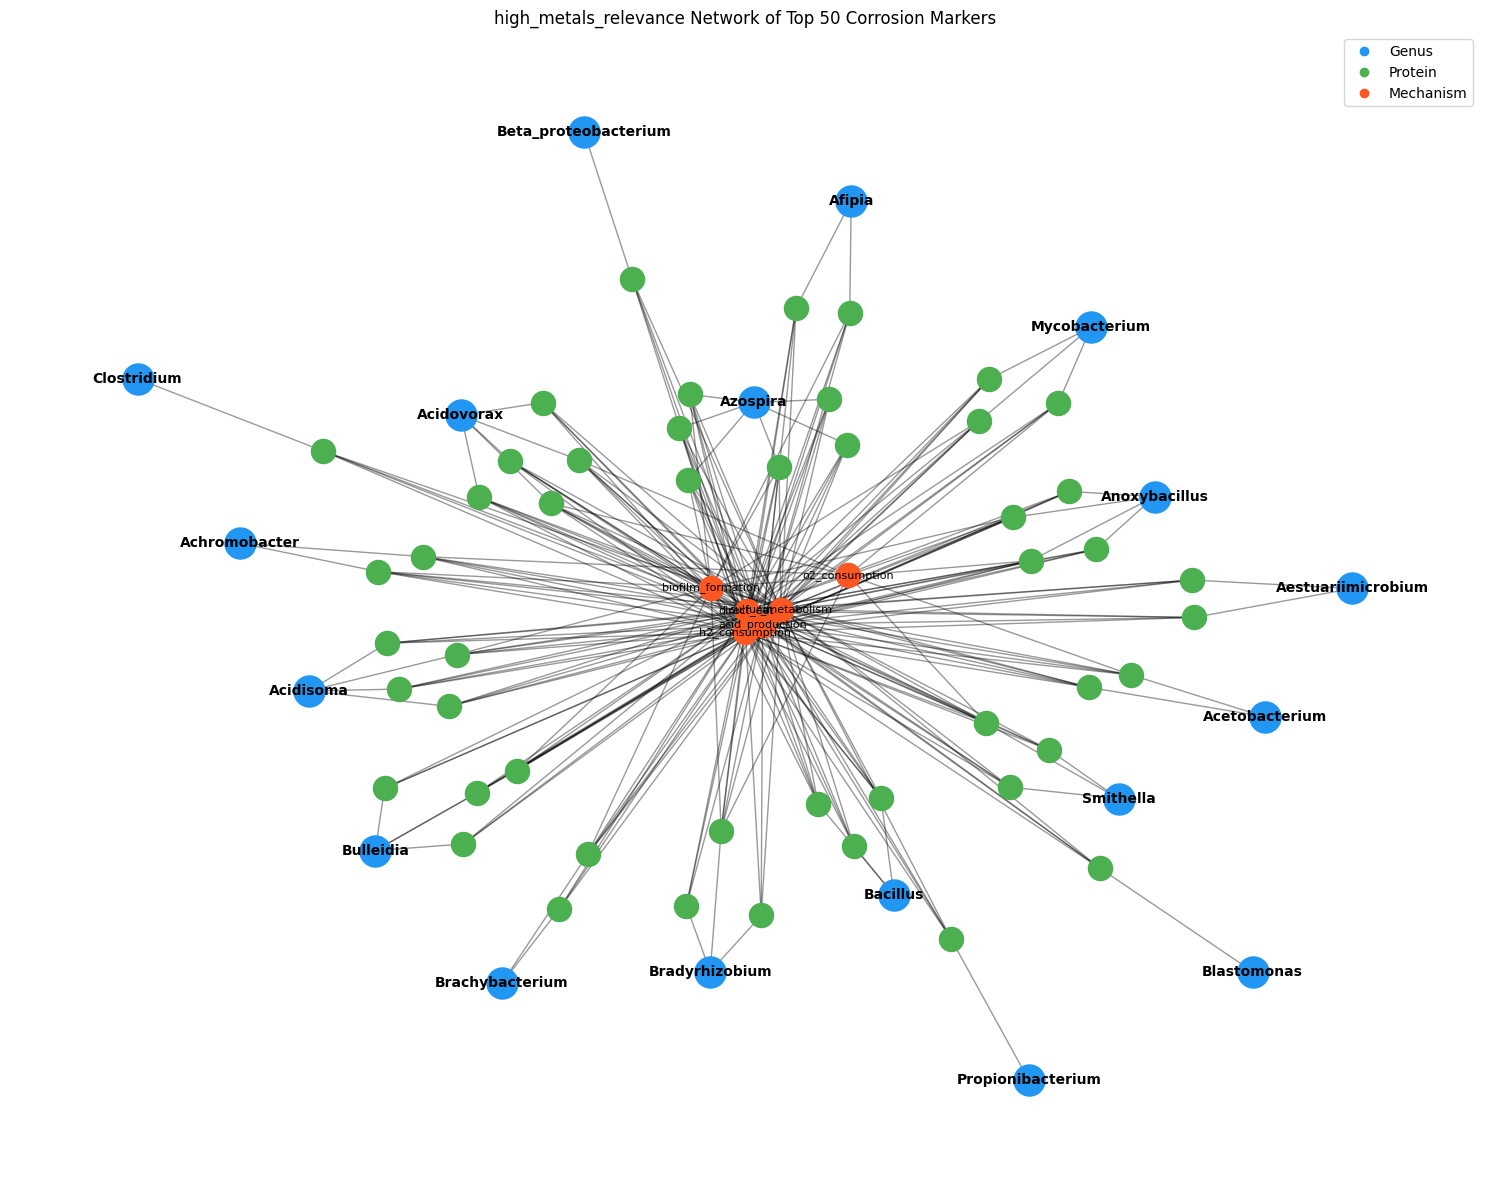

In [48]:
create_static_network(high_metals_relevance,"high_metals_relevance" ,top_n=50, threshold=0.5)

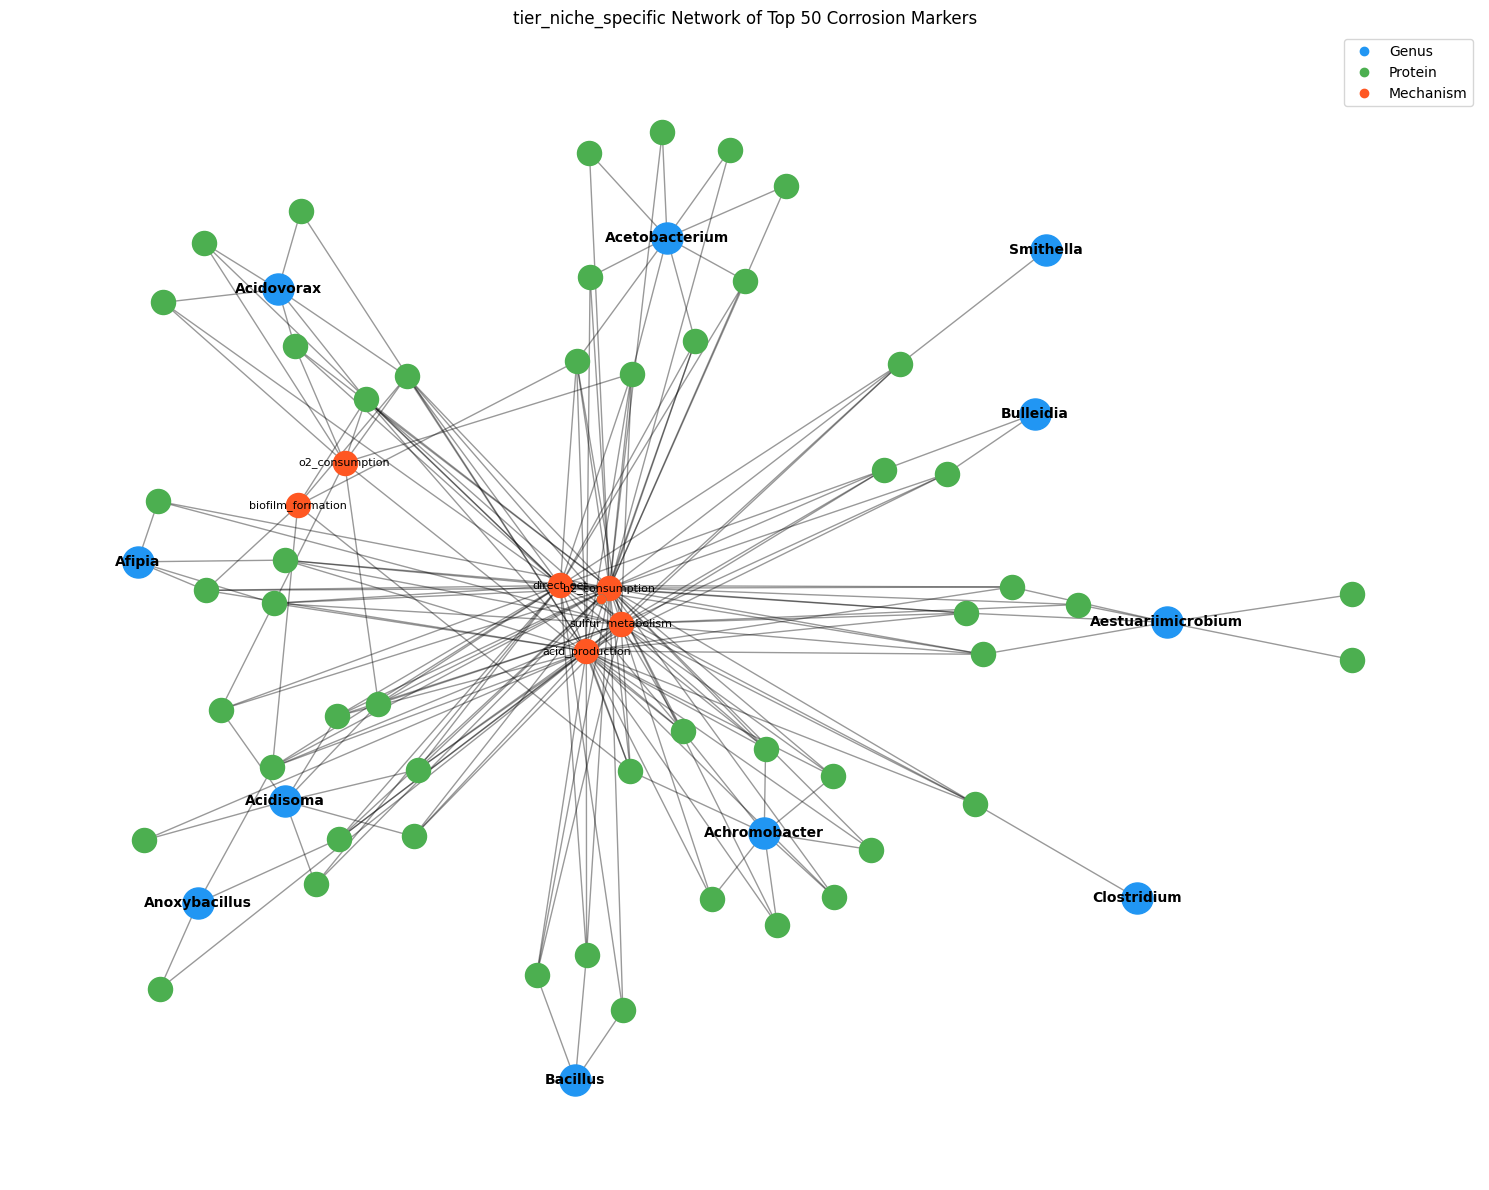

In [43]:

create_static_network(tier_niche_specific,"tier_niche_specific" ,top_n=50, threshold=0.5)

## 3.5. Temporal Transition and Mechanisms Distribution by Risk Categories
### Temporal Transition by Risk Categories

In [ ]:
def temporal_transition(prioritized_markers, name):
    """
    Debugs issues with the temporal transition analysis and creates a Sankey diagram
    showing the flow of proteins between risk categories.
    """
    # Replace values directly within the Series (no rename() on Series)
    prioritized_markers['corrosion_mechanisms'] = prioritized_markers['corrosion_mechanisms'].str.replace('o2_consumption', 'O2_consumption').str.replace('h2_consumption', 'H2_consumption')
    # The issue might be with the 'significant' column - check its values
    sig_results= prioritized_markers.copy(deep=False)

    # Create category dominance for each protein-genus pair
    sig_results['dominant_category'] = sig_results[['mean_cat1', 'mean_cat2', 'mean_cat3']].idxmax(axis=1)
    sig_results['dominant_category'] = sig_results['dominant_category'].map({
        'mean_cat1': 'Category 1',
        'mean_cat2': 'Category 2',
        'mean_cat3': 'Category 3'
    })

    print(f"Distribution by dominant category: {sig_results['dominant_category'].value_counts().to_dict()}")

    # Group by genus and corrosion mechanism
    flow_data = []
    mechanisms_set = set()

    # Try different separator characters
    for separator in [';', ',', '|']:
        print(f"\nTrying separator: '{separator}'")
        mechanism_count = 0

        for _, row in sig_results.iterrows():
            if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
                mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(separator) if m.strip()]
                mechanism_count += len(mechanisms)

                if len(mechanisms) > 0:
                    # If we found mechanisms, break out of the separator loop
                    break

        print(f"Found {mechanism_count} mechanisms with separator '{separator}'")
        if mechanism_count > 0:
            # We found our separator
            break

    # Use the best separator found
    for _, row in sig_results.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(separator) if m.strip()]

            for m in mechanisms:
                mechanisms_set.add(m)  # Track all unique mechanisms

                # Determine the dominant category for this protein
                dom_cat = row['dominant_category']

                # Add a flow from mechanism to dominant category
                flow_data.append({
                    'source': m,
                    'target': dom_cat,
                    'value': 1,  # Count each protein once
                    'genus': row['Genus'],
                    'protein': row['protein_name']
                })

    # Convert to DataFrame
    import pandas as pd
    flow_df = pd.DataFrame(flow_data)

    # Print some diagnostic info
    print(f"\nNumber of unique mechanisms: {len(mechanisms_set)}")
    print(f"Number of flows: {len(flow_df)}")

    # Check if we have any data before proceeding
    if len(flow_df) == 0:
        print("No flows found. Check the corrosion_mechanisms data format.")
        return None

     # Define the order of mechanisms acording to energy requeriments
    mechanism_order = [
        "O2_consumption",
        "H2_consumption",
        "direct_eet",
        "iron_metabolism",
        "sulfur_metabolism",
        "acid_formation",
        "biofilm_formation"
    ]

    # Filter to only include mechanisms that exist in the data
    mechanisms = [m for m in mechanism_order if m in mechanisms_set]

    # Add any mechanisms that weren't in the predefined order
    other_mechanisms = sorted(list(mechanisms_set - set(mechanism_order)))
    mechanisms.extend(other_mechanisms)

    # Categories in order
    categories = ['Category 1', 'Category 2', 'Category 3']
    all_nodes = mechanisms + categories

    # Map source and target to indices
    node_indices = {node: i for i, node in enumerate(all_nodes)}

    flow_df['source_idx'] = flow_df['source'].map(node_indices)
    flow_df['target_idx'] = flow_df['target'].map(node_indices)

    # Aggregate flows by source and target
    agg_flows = flow_df.groupby(['source_idx', 'target_idx']).size().reset_index(name='value')

    # Define node colors - use specified category colors
    category_colors = {
        'Category 1': '#008800',  # Dark green
        'Category 2': '#FF8C00',  # Dark orange
        'Category 3': '#FF0000'   # Red
    }

    # Generate mechanism colors - use a gradient
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from matplotlib.colors import rgb2hex
    import numpy as np

    cmap = plt.cm.get_cmap('viridis', len(mechanisms))
    mechanism_colors = {m: rgb2hex(cmap(i)[:3]) for i, m in enumerate(mechanisms)}

    # Combine all colors
    node_colors = [mechanism_colors.get(node, '#9467bd') if node in mechanisms
                  else category_colors.get(node, '#1f77b4') for node in all_nodes]

    # Create labels with proper formatting
    labels = []
    for node in all_nodes:
        if node in mechanisms:
            # Truncate long mechanism names
            if len(node) > 25:
                labels.append(node[:22] + '...')
            else:
                labels.append(node)
        else:
            # Format category names
            labels.append(node)

    # Create Sankey diagram
    import plotly.graph_objects as go
    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",  # Help prevent overlapping
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
            hoverinfo="all",
            hovertemplate="<b>%{label}</b><br>Count: %{value}<extra></extra>"
        ),
        link=dict(
            source=agg_flows['source_idx'],
            target=agg_flows['target_idx'],
            value=agg_flows['value'],
            hovertemplate="<b>%{source.label}</b> → <b>%{target.label}</b><br>Count: %{value}<extra></extra>"
        )
    )])

    fig.update_layout(
        title_text=(f"Metabolic Mechanisms flow for {name} group according to Risk Categories"),
        font_size=12,
        height=800,
        width=1200, margin=dict(l=50, r=50, t=50, b=50))

    return fig

In [50]:
fig = temporal_transition(classified_results, "classified_results")
fig.show()
fig = temporal_transition(significant_markers, "significant_markers")
fig.show()

Distribution by dominant category: {'Category 2': 19586, 'Category 3': 18744, 'Category 1': 11381}

Trying separator: ';'
Found 4 mechanisms with separator ';'

Number of unique mechanisms: 7
Number of flows: 156550


Distribution by dominant category: {'Category 3': 101, 'Category 2': 61}

Trying separator: ';'
Found 4 mechanisms with separator ';'

Number of unique mechanisms: 6
Number of flows: 479


## 3.6 Mechanism Distribution across Risk Category

In [125]:
def plot_mechanism_distribution(prioritized_markers, name):
    """
    Creates stacked bar charts showing mechanism distribution across risk categories.
    """
    # Define colors and categories
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }

    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }

    # Process mechanism data
    mech_data = []

    for _, row in prioritized_markers.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                mech_data.append({
                    'corrosion_mechanisms': mech,
                    'Category 1': row['mean_cat1'],
                    'Category 2': row['mean_cat2'],
                    'Category 3': row['mean_cat3']
                })

    # Convert to DataFrame
    mech_df = pd.DataFrame(mech_data)

    # Group by mechanism
    grouped = mech_df.groupby('corrosion_mechanisms').agg({
        'Category 1': 'sum',
        'Category 2': 'sum',
        'Category 3': 'sum'
    }).reset_index()

    # Calculate total abundance and sort
    grouped['total'] = grouped['Category 1'] + grouped['Category 2'] + grouped['Category 3']
    grouped = grouped.sort_values('total', ascending=False).head(10)

    # Prepare data for stacked bar chart
    data = []

    for category, color in zip(['Category 1', 'Category 2', 'Category 3'], category_colors.values()):
        data.append(
            go.Bar(
                name=category,
                x=grouped['corrosion_mechanisms'],
                y=grouped[category],
                text=grouped[category].round(2),
                textposition='auto',
                marker_color=color
            )
        )

    # Create figure
    fig = go.Figure(data=data)

    # Update layout
    fig.update_layout(
        barmode='stack',
        title=f"Top 10 Corrosion Mechanisms for Group {name} by Risk Category",
        xaxis_title='Corrosion Mechanisms',
        yaxis_title='Total Abundance',
        legend_title='Risk Category',
        hovermode='x',
        height=600,
        width=1000
    )

    return fig
    plt.show()

plot_mechanism_distribution(high_corrosion_relevance, "high_corrosion_relevance")

## 3.7 A  Dinamic Cluster Analysis UMAP visualizations colored by protein metadata

In [ ]:
def create_dash_umap_visualization(marker_data, name):
    """
    Creates a Dash application with an interactive UMAP visualization
    of protein data with improved legend handling and interactivity
    
    Args:
        marker_data: DataFrame containing protein data and metadata
        
    Returns:
        Dash application object
    """
    # Create the Dash app
    app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
    
    # Get available columns for coloring
    metadata_columns = [col for col in marker_data.columns 
                        if not col.startswith('mean_') and col not in ['protein_name', 'Genus']]
    
    # Create app layout
    app.layout = html.Div([
        html.H2("Interactive Protein UMAP Visualization", style={'textAlign': 'center', 'margin': '20px'}),
        
        dbc.Row([
            # Controls panel
            dbc.Col([
                dbc.Card([
                    dbc.CardHeader("UMAP Controls"),
                    dbc.CardBody([
                        html.Label("Color By:"),
                        dcc.Dropdown(
                            id='color-by-dropdown',
                            options=[{'label': col, 'value': col} for col in metadata_columns],
                            value='corrosion_mechanisms' if 'corrosion_mechanisms' in metadata_columns else metadata_columns[0],
                            clearable=False
                        ),
                        html.Br(),
                        
                        html.Label("n_neighbors:"),
                        dcc.Slider(
                            id='n-neighbors-slider',
                            min=5,
                            max=50,
                            step=5,
                            value=15,
                            marks={i: str(i) for i in range(5, 51, 5)}
                        ),
                        html.Br(),
                        
                        html.Label("min_dist:"),
                        dcc.Slider(
                            id='min-dist-slider',
                            min=0.0,
                            max=0.9,
                            step=0.1,
                            value=0.1,
                            marks={i/10: str(i/10) for i in range(0, 10)}
                        ),
                        html.Br(),
                        
                        html.Label("Show Labels:"),
                        dbc.Checklist(
                            id='show-labels-toggle',
                            options=[
                                {'label': 'Show Labels', 'value': 'show'}
                            ],
                            value=['show']
                        ),
                        html.Br(),
                        
                        html.Label("Label Size:"),
                        dcc.Slider(
                            id='label-size-slider',
                            min=6,
                            max=14,
                            step=1,
                            value=10,
                            marks={i: str(i) for i in range(6, 15, 2)}
                        ),
                        html.Br(),
                        
                        html.Label("Point Size:"),
                        dcc.Slider(
                            id='point-size-slider',
                            min=5,
                            max=20,
                            step=1,
                            value=10,
                            marks={i: str(i) for i in range(5, 21, 5)}
                        ),
                        html.Br(),
                        
                        dbc.Button("Reset View", id="reset-button", color="primary")
                    ])
                ])
            ], width=3),
            
            # UMAP visualization
            dbc.Col([
                dcc.Loading(
                    id="loading-umap",
                    type="default",
                    children=dcc.Graph(id='umap-graph', style={'height': '80vh'})
                )
            ], width=9)
        ]),
        
        dbc.Row([
            dbc.Col([
                html.Div(id='selected-point-info', style={'margin': '20px'})
            ])
        ])
    ])
    
    @app.callback(
        [Output('umap-graph', 'figure'),
         Output('selected-point-info', 'children')],
        [Input('color-by-dropdown', 'value'),
         Input('n-neighbors-slider', 'value'),
         Input('min-dist-slider', 'value'),
         Input('show-labels-toggle', 'value'),
         Input('label-size-slider', 'value'),
         Input('point-size-slider', 'value'),
         Input('reset-button', 'n_clicks'),
         Input('umap-graph', 'clickData')]
    )
    def update_umap(color_by, n_neighbors, min_dist, show_labels, 
                   label_size, point_size, n_clicks, click_data):
        # Extract numerical data for UMAP
        numerical_cols = [col for col in marker_data.columns if col.startswith('mean_')]
        
        if len(numerical_cols) == 0:
            return go.Figure().update_layout(
                title="Error: No numerical columns found for UMAP projection",
                annotations=[{
                    'text': "No columns beginning with 'mean_' were found in the data",
                    'showarrow': False,
                    'font': {'size': 16}
                }]
            ), "No data available"
        
        # Prepare data for UMAP
        X = marker_data[numerical_cols].values
        
        # Create UMAP projection
        umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = umap_model.fit_transform(X)
        
        # Create a DataFrame with the embedding
        umap_df = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'protein_name': marker_data['protein_name'].values,
            'Genus': marker_data['Genus'].values,
            'label': marker_data['Genus'] + '-' + marker_data['protein_name'].str[:10]
        })
        
        # Add the color column if it exists
        if color_by in marker_data.columns:
            umap_df[color_by] = marker_data[color_by].values
        
        # Create the figure
        if color_by in marker_data.columns:
            # Check if categorical or numerical
            if marker_data[color_by].dtype == 'object':
                # Categorical coloring
                fig = px.scatter(
                    umap_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    color=color_by,
                    hover_name='label',
                    hover_data=['protein_name', 'Genus'],
                    size_max=point_size,
                    opacity=0.7,
                    title=f'UMAP Projection of Protein Data for the Group {name} Colored by {color_by}'
                )
                
                # Improve legend appearance for categorical data
                fig.update_layout(
                    legend=dict(
                        orientation="h",
                        yanchor="bottom",
                        y=-0.2,
                        xanchor="center",
                        x=0.5,
                        font=dict(size=10),
                        itemsizing='constant'
                    )
                )
            else:
                # Numerical coloring
                fig = px.scatter(
                    umap_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    color=color_by,
                    hover_name='label',
                    hover_data=['protein_name', 'Genus'],
                    size_max=point_size,
                    opacity=0.7,
                    color_continuous_scale='viridis',
                    title=f'UMAP Projection of Protein Data for the Group {name} Colored by {color_by}'
                )
        else:
            # Default coloring
            fig = px.scatter(
                umap_df, 
                x='UMAP1', 
                y='UMAP2',
                hover_name='label',
                hover_data=['protein_name', 'Genus'],
                size_max=point_size,
                opacity=0.7,
                title='UMAP Projection of Protein Data'
            )
        
        # Add labels conditionally
        if 'show' in show_labels:
            for i, row in umap_df.iterrows():
                fig.add_annotation(
                    x=row['UMAP1'],
                    y=row['UMAP2'],
                    text=row['label'],
                    showarrow=False,
                    font=dict(size=label_size),
                    xshift=10,
                    yshift=10,
                    bgcolor="rgba(255, 255, 255, 0.5)"  # Semi-transparent background
                )
        
        # Update layout
        fig.update_layout(
            xaxis_title="UMAP Dimension 1",
            yaxis_title="UMAP Dimension 2",
            legend_title=color_by,
            height=700,
            margin=dict(l=10, r=10, t=80, b=80 if color_by in marker_data.columns and marker_data[color_by].dtype == 'object' else 10),
            hovermode='closest'
        )
        
        # Uniform marker size
        fig.update_traces(marker=dict(size=point_size))
        
        # Show information for clicked point
        if click_data:
            point_index = click_data['points'][0]['pointIndex']
            point_info = marker_data.iloc[point_index]
            
            info_html = html.Div([
                html.H5(f"Selected Protein: {point_info['protein_name']}"),
                html.P(f"Genus: {point_info['Genus']}"),
                html.P(f"Mechanism: {point_info.get('corrosion_mechanisms', 'N/A')}"),
                
                html.H6("Additional Information:"),
                html.Ul([
                    html.Li(f"{col}: {point_info[col]}") 
                    for col in point_info.index 
                    if col not in ['protein_name', 'Genus', 'corrosion_mechanisms'] 
                    and not col.startswith('mean_')
                ])
            ])
        else:
            info_html = html.Div([
                html.P("Click on a point to see detailed information")
            ])
        
        return fig, info_html
    
    return app

# umap visualising 

app = create_dash_umap_visualization(top_markers, name)
app.run(debug=True)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:



## 3.7 B Static  Cluster Analysis UMAP visualizations colored by protein metadata- static

In [ ]:
def create_simple_umap_visualization(marker_data,  name, top_n= 20, n_neighbors=15, min_dist=0.1, point_size=50, random_state=42):
    """
    Creates a basic UMAP visualization colored by dominant category
    """
    from matplotlib.lines import Line2D
    
    # Define the category colors as in original code
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    
    marker_data = marker_data.head(top_n)
    # Extract numerical data for UMAP
    numerical_cols = [col for col in marker_data.columns if col.startswith('mean_')]
    X = marker_data[numerical_cols].values
    
    # Create UMAP projection
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    embedding = umap_model.fit_transform(X)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Determine dominant category for each data point
    cat_columns = ['mean_cat1', 'mean_cat2', 'mean_cat3']
    dominant_cats = marker_data[cat_columns].idxmax(axis=1).map(lambda x: int(x[-1]))
    
    # Create a list of colors based on dominant category
    colors = [category_colors[cat] for cat in dominant_cats]
    
    # Create scatter plot
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=point_size, alpha=0.7)
    
    # Create legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
               label=label, markersize=10)
        for cat, (color, label) in enumerate(zip(
            [category_colors[1], category_colors[2], category_colors[3]],
            [categories_labels[1], categories_labels[2], categories_labels[3]]
        ), 1)
    ]
    
    ax.legend(handles=legend_elements, title="Dominant Category", 
             bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add basic labels
    for i, (_, row) in enumerate(marker_data.iterrows()):
        label = f"{row['Genus']}-{str(row['protein_name'])[:10]}"
        ax.text(embedding[i, 0], embedding[i, 1], label, 
              fontsize=8, ha='right', va='top',
              bbox=dict(facecolor='white', alpha=0.3, pad=0.6))
    
    # Set title and labels
    ax.set_title(f"UMAP Projection of Protein Data for group {name}", fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=14)
    ax.set_ylabel('UMAP Dimension 2', fontsize=14)
    
    plt.tight_layout()
    return fig

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



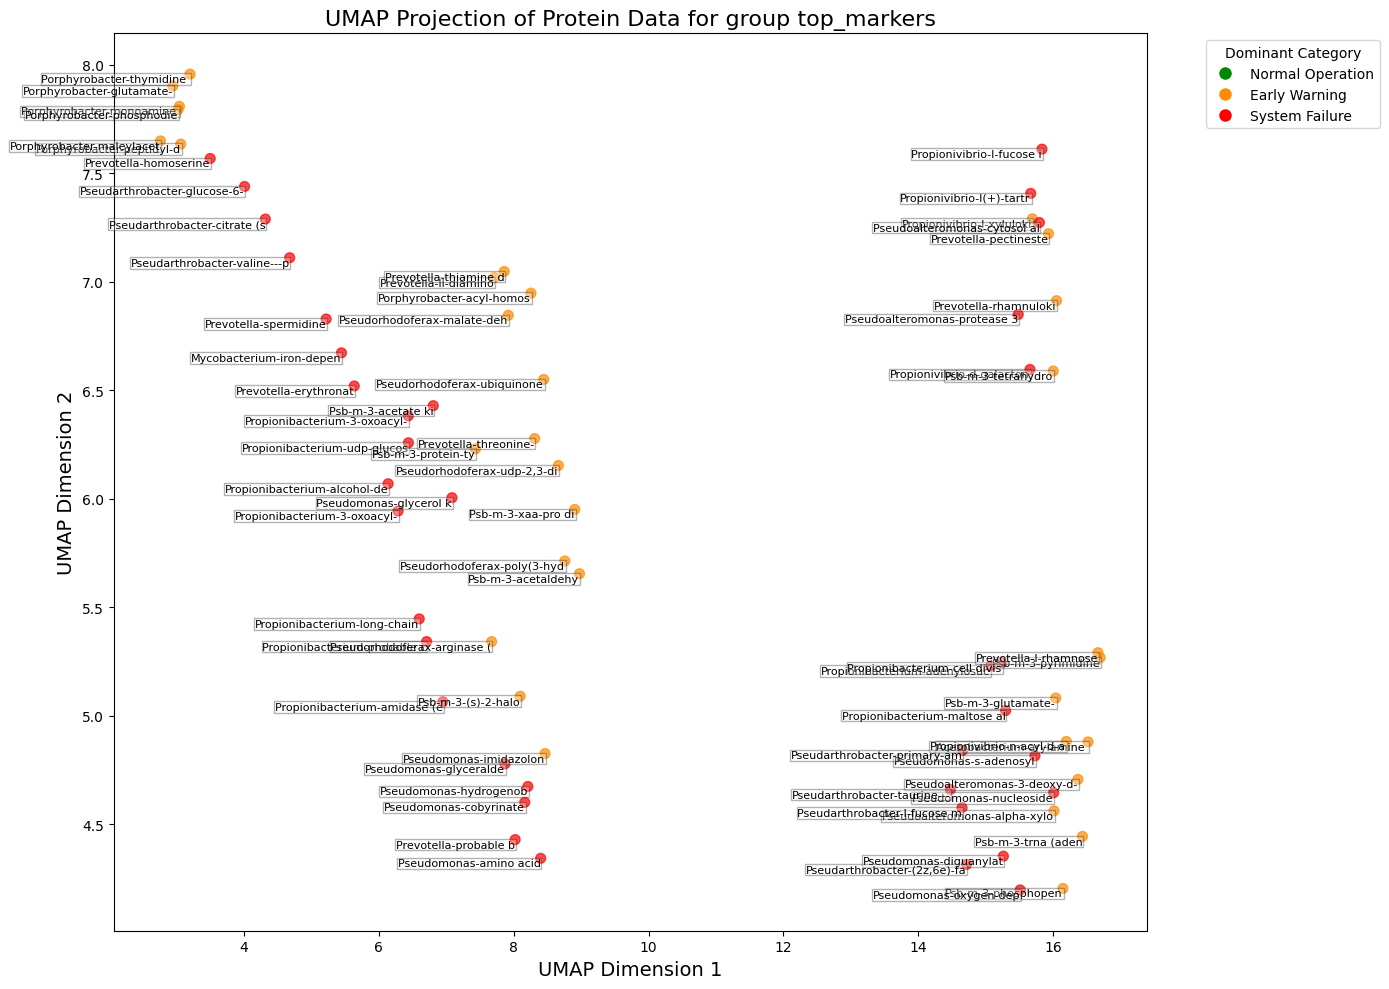

In [127]:
plot = create_simple_umap_visualization(top_markers, "top_markers", 70, n_neighbors=10, min_dist=0.1, point_size=50)
# Display the figure
plt.show()

The group top_markers shows that the system failure markers (red) dominate the majority of the plot and appear in almost all bacterial genera, which is expected because those are the filtered pair genus-protein markers coming from the pipeline in which were classified, scored and separated according to the bacteria abundance, relationship to the risk label and biological relevance scoring, so it is no a surprise if only category 2 and 3 are present. In the system failure some protein-genus are associated such as propionibacterium and Propionivibrio proteins, most Pseudarthrobacter proteins and several Pseudomonas proteins. The category 2, early warning markers (orange) cluster prominently in the right side of the plot (Porphyrobacter proteins), appear in selected Pseudorhodeferax proteins and several instances in Prevotella markers.

The Porphyrobacter cluster (right side) is predominantly associated with early warning status
Propionibacterium/Propionivibrio clusters (upper left) primarily indicate system failure
Pseudarthrobacter markers in the middle regions consistently indicate system failure. There is biological coherence since those enzymatic functions align strongly with the operational indicators.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



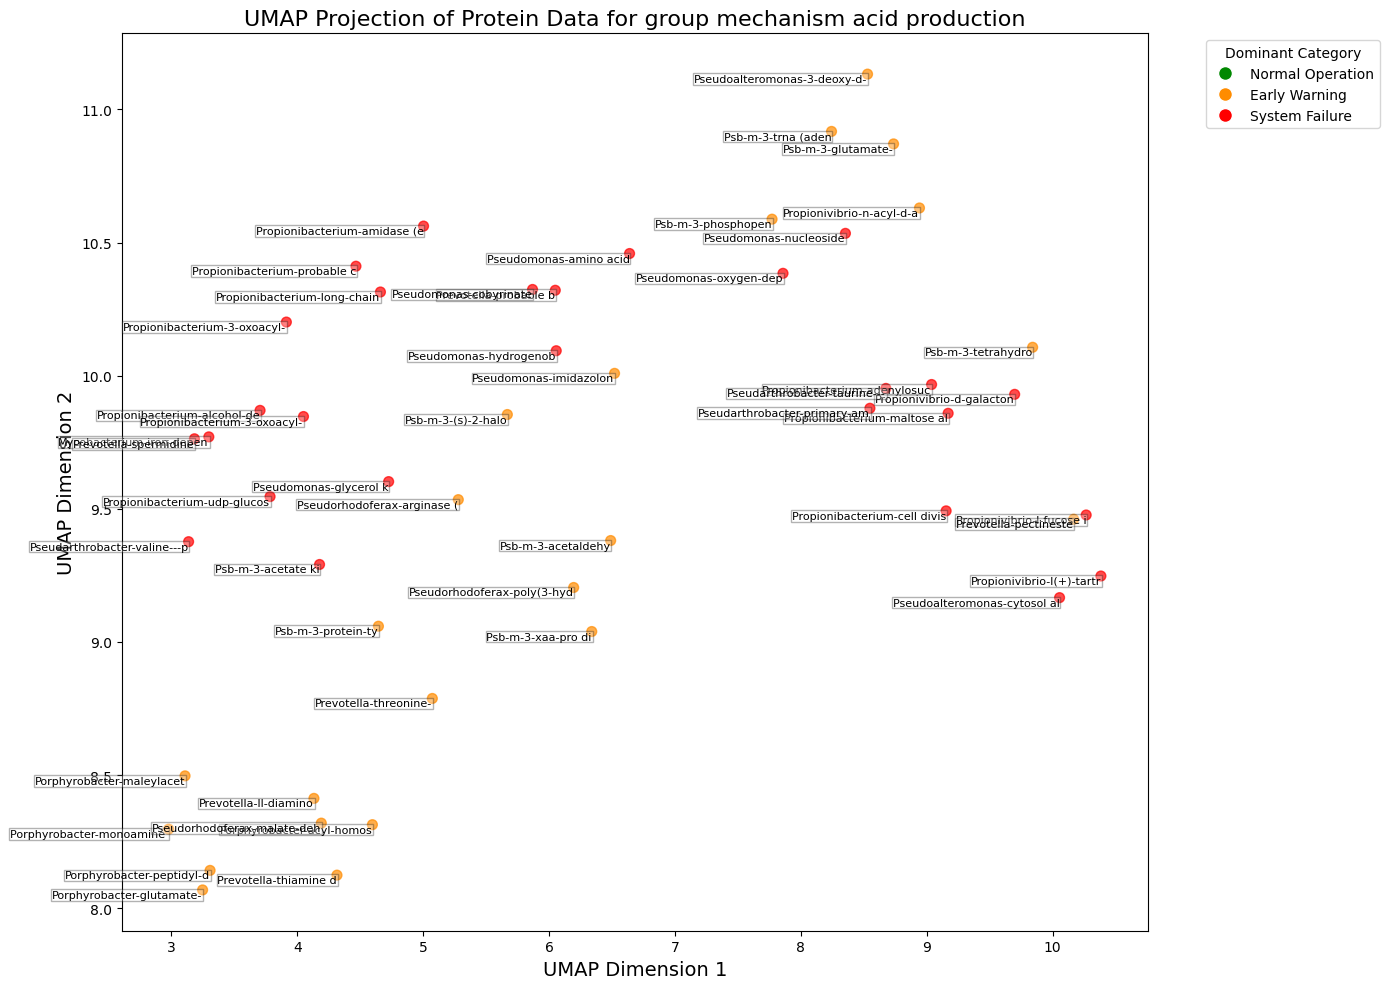

In [128]:

plot = create_simple_umap_visualization(mechanism_acid_production, "mechanism acid production", 50, n_neighbors=10, min_dist=0.1, point_size=50)
plt.show()


The umap proyection on group mechanism_acid_production show several clusters, sytem failure markers dominated the plot, in the bottom left 
Propionibacterium acid-producing enzymes, Pseudomonas, Propionivibrio, psb-m-3 and prevotela metabolic enzymes.Category 2 early warning markers (orange) show functional patterns: Prevotella enzymes (thiamine, threonine, diaminopimelate metabolism), selected Pseudorhodeferax proteins and Porphyrobacter acyl-homos proteins. The acid production mechanisms appear to have predictive value for system states, with specific metagenomic signatures correlating with different operational conditions.
Genus-level patterns emerge: Porphyrobacter appears to be an early warning indicator genus, Propionibacterium/Propionivibrio markers consistently signal system failure
Prevotella shows mixed indicators between early warning and system failure. Acid production enzymes strongly correlate with system status, transferases and certain dehydrogenases appear to have early warning potential. The cytosol and cell division proteins show consistent system failure indications. This suggests these enzyme functions have genuine predictive value

## 3.8. Functional categories Mechanism/Pathway heatmaps

In [65]:
def plot_functional_group_heatmap(classified_results, name, top_n=100):
    """
    Create side-by-side heatmaps grouped by mechanisms and pathway classification
    
    Parameters:
        classified_results: DataFrame with classified pathways
        name: Name of the group for title
        top_n: Number of top pairs to use (default: 100)
    
    Returns:
        matplotlib figure
    """
    # Get top markers
    top_markers = classified_results.head(top_n)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # First subplot: Mechanisms
    if 'corrosion_mechanisms' in top_markers.columns:
        # Extract all mechanisms
        all_mechanisms = set()
        for mechs in top_markers['corrosion_mechanisms'].dropna():
            if isinstance(mechs, str):
                all_mechanisms.update([m.strip() for m in mechs.split(';')])
        
        # Create a matrix: rows=genera, columns=mechanisms
        genera = top_markers['Genus'].unique()
        mechanisms = sorted(list(all_mechanisms))
        matrix = np.zeros((len(genera), len(mechanisms)))
        
        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]
            for _, row in genus_markers.iterrows():
                if pd.notna(row['corrosion_mechanisms']) and isinstance(row['corrosion_mechanisms'], str):
                    marker_mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                    for mechanism in marker_mechanisms:
                        if mechanism in mechanisms:
                            j = mechanisms.index(mechanism)
                            matrix[i, j] += 1
        
        # Use a better colormap for mechanisms
        cmap1 = LinearSegmentedColormap.from_list('corrosion', ['#FFFFFF', '#FF9966', '#CC3300'])
        sns.heatmap(matrix, cmap=cmap1, linewidths=0.5, linecolor='gray',
                   xticklabels=mechanisms, yticklabels=genera, ax=ax1)
        ax1.set_title(f'Genus-Mechanism Relationship')
        ax1.set_xlabel('Corrosion Mechanism')
        ax1.set_ylabel('Genus')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Second subplot: Pathway classification
    if 'pathway_classification' in top_markers.columns:
        # Create a matrix: rows=genera, columns=classifications
        genera = top_markers['Genus'].unique()
        classifications = ['universal', 'mixed', 'niche-specific']
        matrix = np.zeros((len(genera), len(classifications)))
        
        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]
            for classification in classifications:
                j = classifications.index(classification)
                count = sum(genus_markers['pathway_classification'] == classification)
                matrix[i, j] = count
        
        # Plot
        cmap2 = LinearSegmentedColormap.from_list('pathways', ['#FFFFFF', '#66CCFF', '#003366'])
        sns.heatmap(matrix, cmap=cmap2, linewidths=0.5, linecolor='gray',
                   xticklabels=classifications, yticklabels=genera, ax=ax2)
        ax2.set_title(f"Genus-Pathway Classification Relationship")
        ax2.set_xlabel('Pathway Classification')
        ax2.set_ylabel('Genus')
    
    # Overall title
    plt.suptitle(f"Functional Relationships for {name} (Top {top_n} Proteins)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    
    return fig

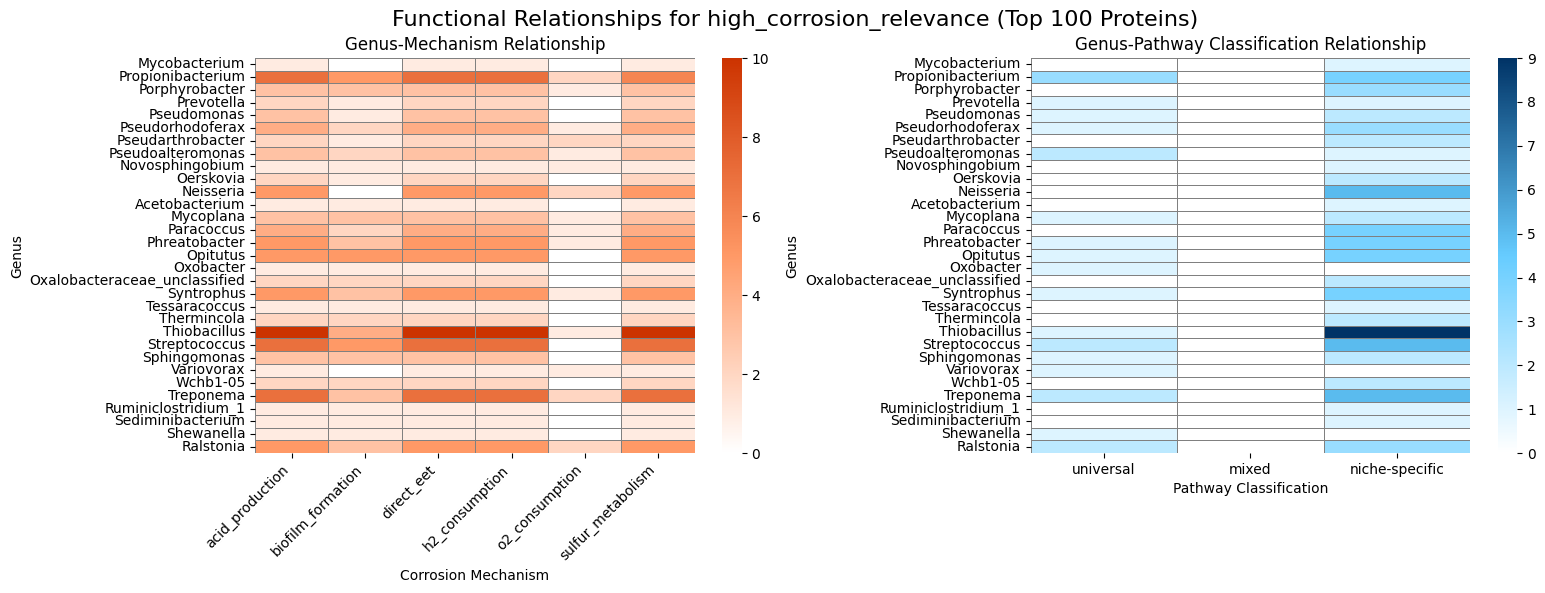

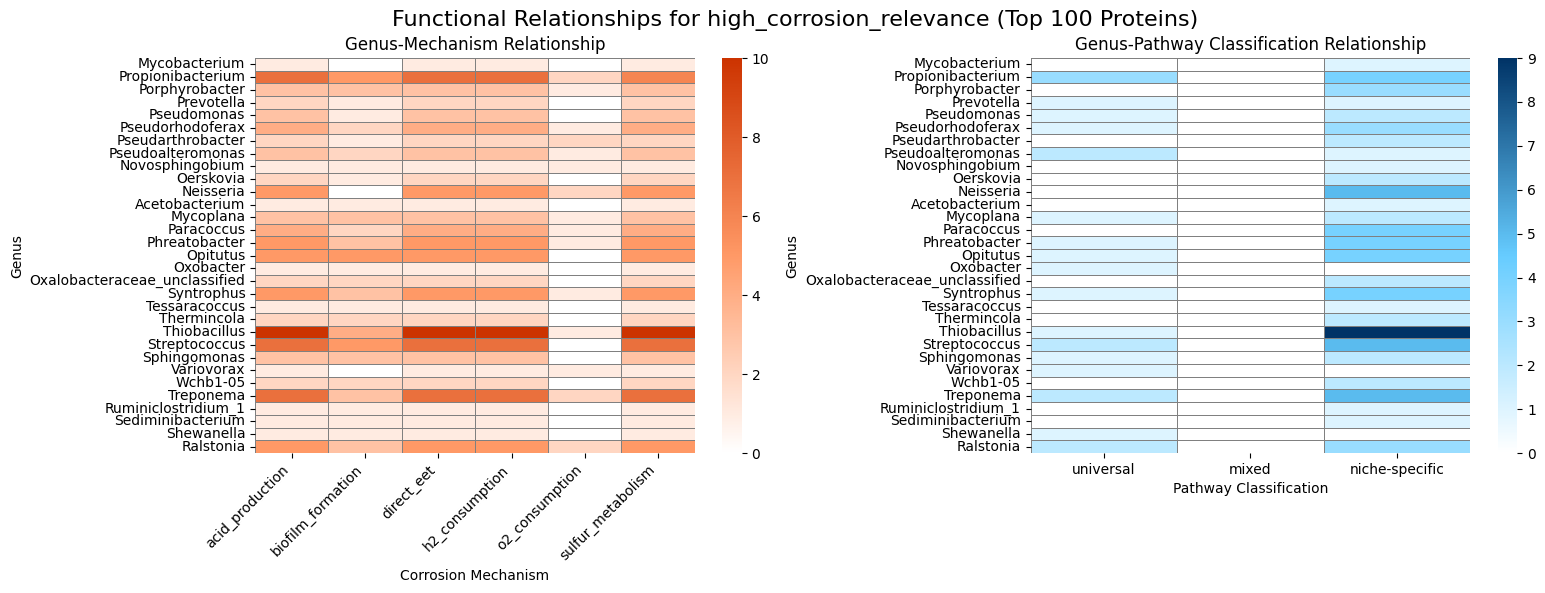

In [ ]:
plot_functional_group_heatmap(high_corrosion_relevance, "high_corrosion_relevance", top_n=100)
plt.show()

## 3.9. Genus-Mechanism Heatmap
Shows relationships between top genera and corrosion mechanisms

<Figure size 640x480 with 0 Axes>

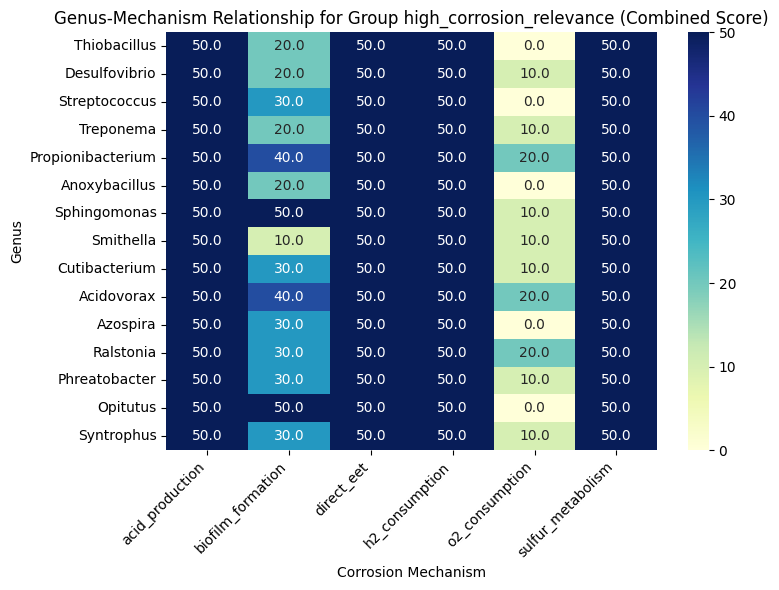

<Figure size 640x480 with 0 Axes>

In [129]:
def plot_genus_mechanism_heatmap(prioritized_markers, name, top_genera=10, top_markers_per_genus=5, figsize=None):
    """
    Create a heatmap showing top genera and their corrosion mechanisms
    """
    plt.close('all')
    # Ensure corrosion_mechanisms column exists
    if 'corrosion_mechanisms' not in prioritized_markers.columns:
        raise ValueError("DataFrame must contain 'corrosion_mechanisms' column")

    # Get top genera
    top_genera_list = prioritized_markers['Genus'].value_counts().head(top_genera).index.tolist()

    # Filter for top genera
    genus_df = prioritized_markers[prioritized_markers['Genus'].isin(top_genera_list)].copy(deep=False)

    # Get top markers per genus
    top_markers = []
    for genus in top_genera_list:
        genus_markers = genus_df[genus_df['Genus'] == genus].head(top_markers_per_genus)
        top_markers.append(genus_markers)

    top_markers_df = pd.concat(top_markers)

    # Extract all unique mechanisms
    all_mechanisms = set()
    for mechs in top_markers_df['corrosion_mechanisms'].dropna():
        if isinstance(mechs, str):
            all_mechanisms.update([m.strip() for m in mechs.split(';')])

    all_mechanisms = sorted(list(all_mechanisms))

    # Create matrix for heatmap (genus x mechanism)
    heatmap_data = np.zeros((len(top_genera_list), len(all_mechanisms)))

    # Fill matrix with scores
    for i, genus in enumerate(top_genera_list):
        genus_markers = top_markers_df[top_markers_df['Genus'] == genus]

        for _, row in genus_markers.iterrows():
            if pd.notna(row['corrosion_mechanisms']):
                mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                score = row['combined_score']

                for mechanism in mechanisms:
                    if mechanism in all_mechanisms:
                        j = all_mechanisms.index(mechanism)
                        heatmap_data[i, j] += score

    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu',
                xticklabels=all_mechanisms, yticklabels=top_genera_list)

    plt.title(f'Genus-Mechanism Relationship for Group {name} (Combined Score)')
    plt.ylabel('Genus')
    plt.xlabel('Corrosion Mechanism')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.figure() 
    return plt.gcf()

plot_genus_mechanism_heatmap(high_corrosion_relevance, "high_corrosion_relevance", top_genera=15, top_markers_per_genus=5, figsize=(8, 6))

# 4. Proteins 
## 4.1. Protein Abundance Trajectories across risk categories

In [84]:
def plot_protein_trajectories(balanced_markers, top_n=20):
    """
    Creates a line chart showing protein abundance trajectories across risk categories.
    """
    # Select top proteins
    top_proteins = balanced_markers.sort_values('combined_score', ascending=False).head(top_n)

    # Prepare data for trajectories
    trajectories = []

    for i, row in top_proteins.iterrows():
        # Create shorter, more readable labels
        protein_name = row['protein_name']
        if len(protein_name) > 30:
            protein_name = protein_name[:27] + "..."

        label = f"{row['Genus']} - {protein_name}"

        trajectories.append({
            'id': label,
            'Category 1': row['mean_cat1'],
            'Category 2': row['mean_cat2'],
            'Category 3': row['mean_cat3'],
            'pattern': row['pattern'],
            'score': row['combined_score']
        })

    # Convert to DataFrame
    traj_df = pd.DataFrame(trajectories)

    # Melt for plotting
    melted = pd.melt(
        traj_df,
        id_vars=['id', 'pattern', 'score'],
        value_vars=['Category 1', 'Category 2', 'Category 3'],
        var_name='category',
        value_name='abundance'
    )

    # Map categories to numeric values for plotting
    melted['category_num'] = melted['category'].map({
        'Category 1': 1,
        'Category 2': 2,
        'Category 3': 3
    })

    # Create line chart
    fig = px.line(
        melted,
        x='category_num',
        y='abundance',
        color='id',
        line_group='id',
        hover_data=['pattern', 'score'],
        markers=True,
        title='Protein Abundance Trajectories Across Risk Categories',
        labels={'category_num': 'Risk Category', 'abundance': 'Mean Abundance'},
        height=600,
        width=1000
    )

    # Update x-axis
    fig.update_xaxes(
        tickvals=[1, 2, 3],
        ticktext=['Category 1', 'Category 2', 'Category 3']
    )

    # Place legend at the bottom of the chart
    fig.update_layout(
        legend=dict(
            orientation="h",     # horizontal orientation
            yanchor="bottom",
            y=-0.5,              # position below the plot
            xanchor="center",
            x=0.5                # centered horizontally
        ),
        margin=dict(
            b=150                # add bottom margin to accommodate the legend
        )
    )

    return fig

plot_protein_trajectories(high_cat3_vs_cat1_change,  top_n=20)

## 4.2. Protein Abundance Across Categories
Line plots showing how abundance changes across corrosion categories

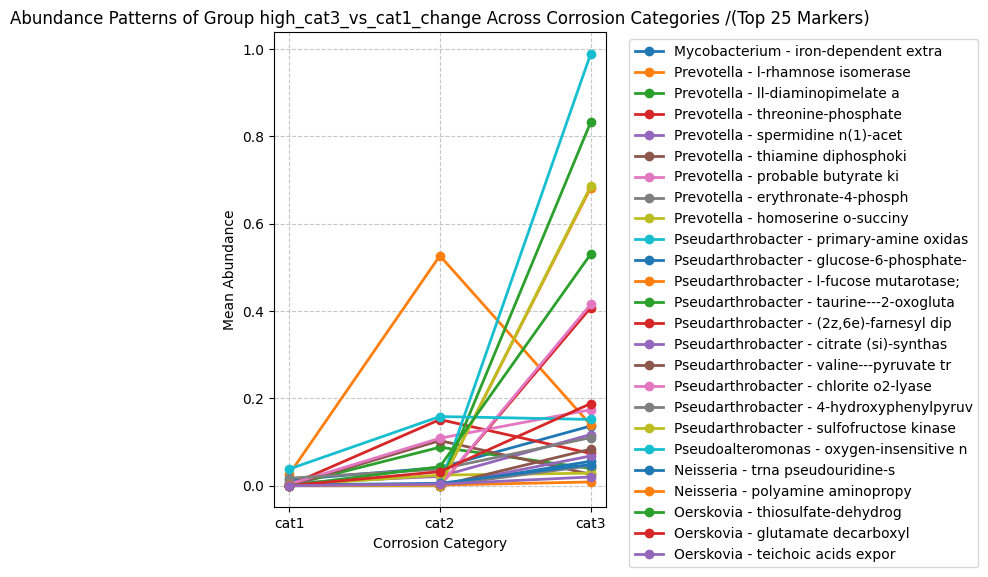

In [124]:
def plot_abundance_across_categories(prioritized_markers, name, top_n=25, figsize=None):
    """
    Plot abundance patterns across corrosion categories for top markers
    """
    # Get mean columns
    mean_cols = [col for col in prioritized_markers.columns if col.startswith('mean_')]

    if not mean_cols:
        raise ValueError("No mean abundance columns found (should start with 'mean_')")

    # Get top markers
    top_markers = prioritized_markers.head(top_n)

    # Extract category numbers from column names
    categories = [col.replace('mean_', '') for col in mean_cols]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot abundance patterns for each marker
    for i, (_, row) in enumerate(top_markers.iterrows()):
        label = f"{row['Genus']} - {row['protein_name'][:20]}"
        values = [row[col] for col in mean_cols]
        plt.plot(categories, values, marker='o', linewidth=2, label=label)

    # Add labels and title
    plt.xlabel('Corrosion Category')
    plt.ylabel('Mean Abundance')
    plt.title(f'Abundance Patterns of Group {name} Across Corrosion Categories /(Top {top_n} Markers)')
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best')

    plt.tight_layout()
    return plt.gcf()

plot_abundance_across_categories(high_cat3_vs_cat1_change, "high_cat3_vs_cat1_change", top_n=25, figsize=(8, 6))
plt.show()

## 4.3. Top Protein Heatmap

In [130]:
def plot_top_protein_heatmap(df, name, top_proteins=20):
    # Sort by preferred significance metric
    top_proteins = df.sort_values(by='significance_score', ascending=False).head(top_proteins)

    # Select mean value columns for heatmap
    heatmap_data = top_proteins[['mean_cat1', 'mean_cat2', 'mean_cat3']]

    # Truncate long protein names for better visualization
    truncated_names = top_proteins['protein_name'].apply(lambda x: x if len(x) <= 70 else x[:17] + '...')

    # Create heatmap
    plt.figure(figsize=(8, 6))  # Adjusted figure size
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".2f",
        cmap='viridis',
        yticklabels=truncated_names,  # Use truncated names
        xticklabels=['Category 1', 'Category 2', 'Category 3']
    )

    plt.title(f" {name}Top Protein Expression Heatmap")
    plt.ylabel("Proteins")
    plt.xlabel("Risk Category")

    # Use tight_layout to minimize empty space
    plt.tight_layout()

    return plt.gcf()


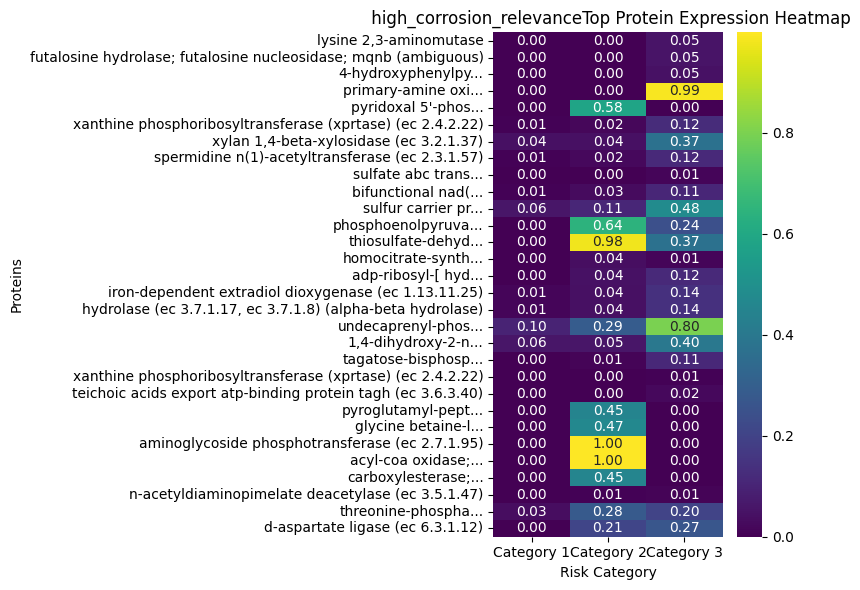

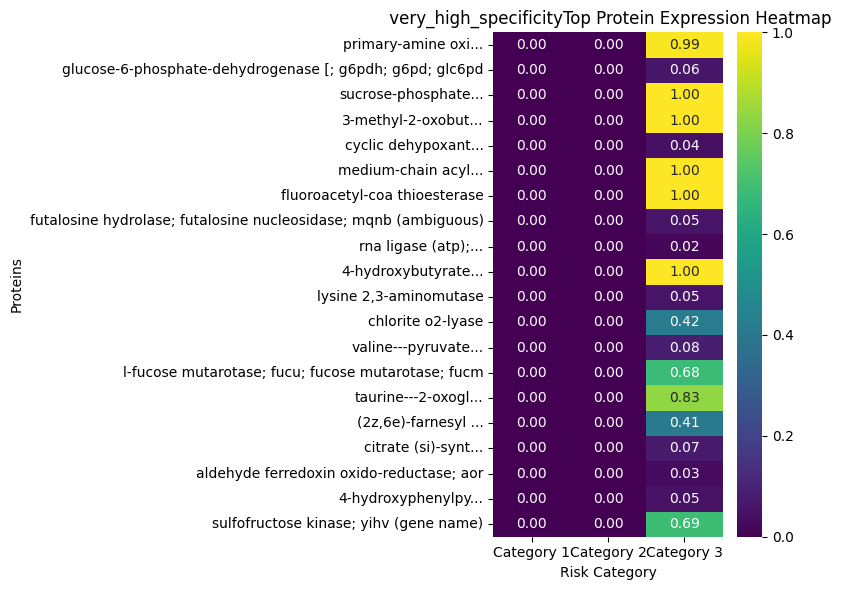

In [131]:
plot_top_protein_heatmap(high_corrosion_relevance, "high_corrosion_relevance", 30)
plt.show()
plot_top_protein_heatmap(very_high_specificity, "very_high_specificity", 20)
plt.show()

## 4.4. Top Markers by Score -
Bar chart showing the highest scoring markers

In [97]:
def plot_top_markers_by_score(prioritized_markers, name, top_n=20, figsize=(8, 6)):
    """
    Create a horizontal bar chart of top markers by score
    """
    # Get top markers
    top_markers = prioritized_markers.head(top_n)

    # Create labels
    labels = [f"{row['Genus']} - {row['protein_name'][:30]}"
              for _, row in top_markers.iterrows()]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot horizontal bars
    plt.barh(range(len(labels)), top_markers['combined_score'], color='steelblue')

    # Add labels and title
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Combined Score')
    plt.title(f'Top {top_n} for the Group {name} Markers by Score')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return plt.gcf()

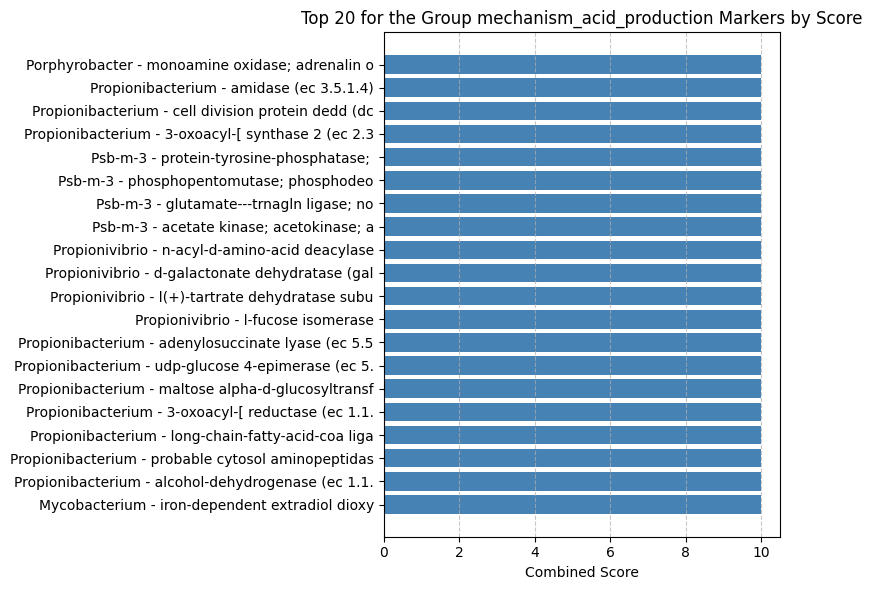

In [101]:
plot_top_markers_by_score(mechanism_acid_production, "mechanism_acid_production", top_n=20, figsize=(8, 6))
plt.show()

# 5. Pathways
## 5.1 Pathway Enrichment across Risk Categories
Plot shows metabolic pathways present in the corrosion environment, how abundant each pathway is across different corrosion risk categories. The pathways increase/decrease with severity or specific conditions
Biological processes are identified, which be involved in corrosion mechanisms across different risk levels.The bubble chart visualization uses
Y-axis: Different metabolic pathways
X-axis: Risk categories (Normal Operation, Early Warning, System Failure)
Bubble size: Mean abundance of the pathway in that category
Bubble color: Pattern type (increasing, decreasing, or unique to a category)

In [133]:
def plot_pathway_enrichment(classified_results, name):
    """
    Creates a bubble chart showing pathway enrichment by risk category,
    accounting for unique patterns in specific categories.
    """
    # Extract top pathways from the dataset
    pathway_data = []

    for _, row in classified_results.iterrows():
        if isinstance(row['pathways'], str) and row['pathways']:
            pathways = [p.strip() for p in row['pathways'].split(';')]
            # Take only the first 3 pathways to avoid overwhelming the plot
            for pathway in pathways: # [:3]
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 1',
                    'mean_abundance': row['mean_cat1'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 2',
                    'mean_abundance': row['mean_cat2'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 3',
                    'mean_abundance': row['mean_cat3'],
                    'classification': row['pathway_classification']
                })

    # Convert to DataFrame
    pathway_df = pd.DataFrame(pathway_data)

    # Group by pathway and category, calculate mean abundance
    grouped = pathway_df.groupby(['pathway', 'category', 'classification'], as_index=False)['mean_abundance'].mean()

    # Add pattern detection: dominant category
    pivot = grouped.pivot_table(index='pathway', columns='category', values='mean_abundance').reset_index()

    # Identify dominant category for each pathway
    pivot['dominant_cat'] = pivot[['Category 1', 'Category 2', 'Category 3']].idxmax(axis=1)
    pivot['max_value'] = pivot[['Category 1', 'Category 2', 'Category 3']].max(axis=1)
    pivot['pattern'] = 'unique_' + pivot['dominant_cat'].str.replace('Category ', 'cat')

    # Calculate fold changes between categories with pseudocounts
    min_threshold = 0.01  # Higher minimum threshold to prevent extreme ratios

    # Cat3 vs Cat1 fold change
    pivot['fold_change_3vs1'] = (pivot['Category 3'] + min_threshold) / (pivot['Category 1'] + min_threshold)
    pivot['log2fc_3vs1'] = np.log2(pivot['fold_change_3vs1'])

    # Cat2 vs Cat1 fold change
    pivot['fold_change_2vs1'] = (pivot['Category 2'] + min_threshold) / (pivot['Category 1'] + min_threshold)
    pivot['log2fc_2vs1'] = np.log2(pivot['fold_change_2vs1'])

    # Cat3 vs Cat2 fold change
    pivot['fold_change_3vs2'] = (pivot['Category 3'] + min_threshold) / (pivot['Category 2'] + min_threshold)
    pivot['log2fc_3vs2'] = np.log2(pivot['fold_change_3vs2'])

    # Identify increasing or decreasing patterns
    # Pattern is "increasing" if Cat1 < Cat2 < Cat3
    pivot['is_increasing'] = (
        (pivot['Category 1'] < pivot['Category 2']) &
        (pivot['Category 2'] < pivot['Category 3'])
    )

    # Pattern is "decreasing" if Cat1 > Cat2 > Cat3
    pivot['is_decreasing'] = (
        (pivot['Category 1'] > pivot['Category 2']) &
        (pivot['Category 2'] > pivot['Category 3'])
    )

    # Update pattern label based on trend
    pivot.loc[pivot['is_increasing'], 'pattern'] = 'increasing'
    pivot.loc[pivot['is_decreasing'], 'pattern'] = 'decreasing'

    # Handle infinity and NaN values with more moderate caps
    for col in ['log2fc_3vs1', 'log2fc_2vs1', 'log2fc_3vs2']:
        pivot[col] = pivot[col].replace([np.inf, -np.inf], [5, -5])  # More moderate caps
        pivot[col] = pivot[col].fillna(0)
    # Merge back the pattern information
    enrichment = pd.merge(
        grouped,
        pivot[['pathway', 'fold_change_3vs1', 'log2fc_3vs1', 'pattern', 'dominant_cat']],
        on='pathway'
    )

    # Get top pathways for each pattern type
    pattern_types = pivot['pattern'].unique()
    top_pathways = []

    for pattern in pattern_types:
        # Get top 5 pathways for this pattern
        pattern_data = enrichment[enrichment['pattern'] == pattern].copy(deep=False)
        if len(pattern_data) > 0:
            if pattern == 'increasing':
                # For increasing, get highest fold change
                top = pattern_data.sort_values('log2fc_3vs1', ascending=False).head(5)
            elif pattern == 'decreasing':
                # For decreasing, get lowest fold change
                top = pattern_data.sort_values('log2fc_3vs1', ascending=True).head(5)
            else:
                # For unique patterns, get highest mean abundance
                top = pattern_data.sort_values('mean_abundance', ascending=False).head(5)
            top_pathways.append(top)

    # Combine all top pathways
    plot_data = pd.concat(top_pathways)

    plot_data = plot_data.dropna(subset=['mean_abundance'])

    # Create a bubble chart
    fig = px.scatter(
        plot_data,
        x='category',
        y='pathway',
        size='mean_abundance',
        size_max=15,
        color='pattern',
        hover_data=['classification', 'mean_abundance'],
        height=400,
        width=800,
        title=(f" Pathway Enrichment for {name} group across Risk Categories"),
        labels={
            'category': 'Risk Category',
            'pathway': 'Metabolic Pathway',
            'mean_abundance': 'Mean Abundance',
            'pattern': 'Abundance Pattern'
        },
        color_discrete_map={
            'increasing': '#4CAF50',  # Green
            'decreasing': '#F44336',  # Red
            'unique_cat1': '#2196F3',  # Blue
            'unique_cat2': '#FF9800',  # Orange
            'unique_cat3': '#9C27B0'   # Purple
        }, category_orders={"category": ["Category 1", "Category 2", "Category 3"]}
    )

    # Update layout for better readability
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        legend_title_text='Abundance Pattern',
        xaxis_title='Risk Category',
        yaxis_title='Metabolic Pathway'
    )

    return fig, pivot

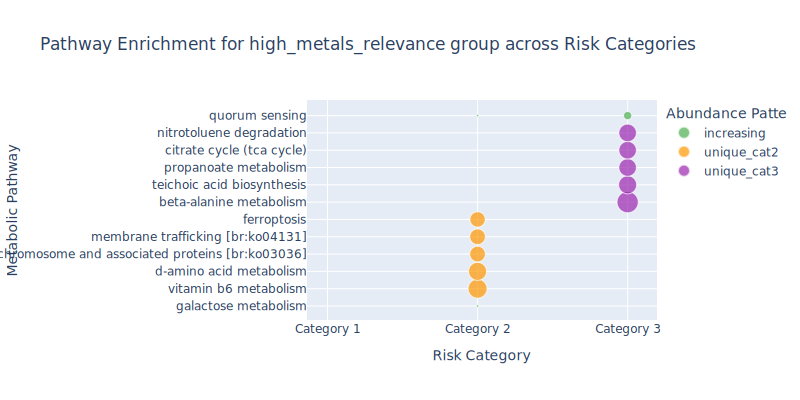

In [134]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(high_metals_relevance, "high_metals_relevance")
Pathway_enrichment.show(renderer="svg")

The group high confidence is the largest one of the selected after balanced markers, the category 3 patterns are marked by prokaryotic defense system which increased drastically from cat1 to cat3. The lipid biosyntesis, aminoacid and cyano amino acid metabolism, nitrotoluene degradation and other fixation pathways only are present on cat3 as well as the quorum sensing which corelates with biofilm stablishement on corroded environments. Markers for early warning cat2 are fatty acids, lipids metabolism, together with flavonoids degradataion which are a bridge to more deteriorated environments.

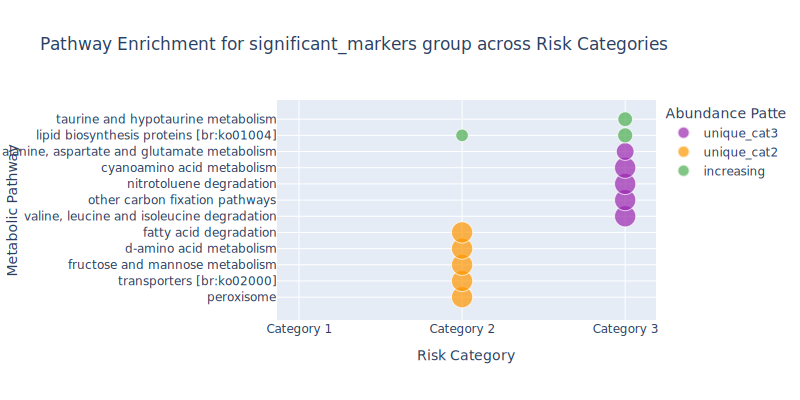

In [135]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(significant_markers, "significant_markers")
Pathway_enrichment.show(renderer="svg")

This is an exploratory visualisation tool for checking relationships between the final selected proteins

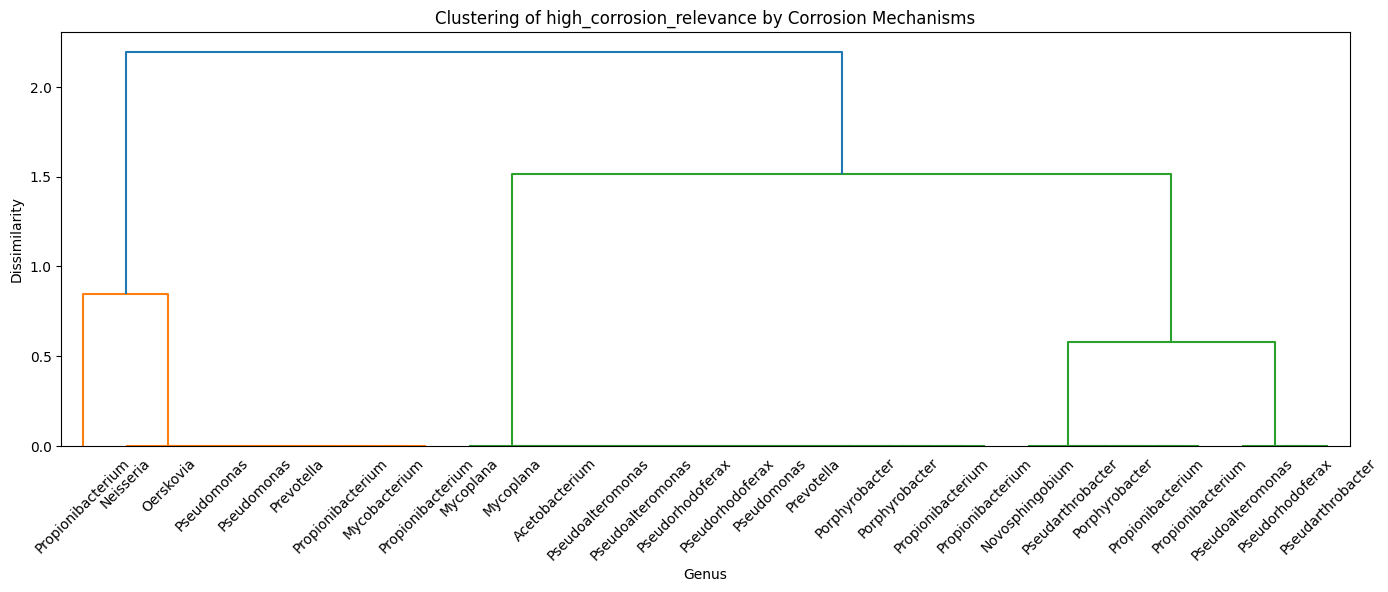

In [137]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
def clustering_markers_by_corrosion_mechanisms(top_markers, name, top_n = 20):
    # starting df
    top_markers = top_markers.copy(deep=False)  
    top_markers = top_markers.head(top_n)

    # Create a binary presence matrix from corrosion_mechanisms
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split(';'), binary=True)
    mech_matrix = vectorizer.fit_transform(top_markers['corrosion_mechanisms'].fillna(''))

    # Compute cosine similarity (1 = identical mechanism sets, 0 = completely different)
    cos_sim = cosine_similarity(mech_matrix)

    # Hierarchical clustering
    from scipy.cluster.hierarchy import linkage, dendrogram
    linkage_matrix = linkage(1 - cos_sim, method='average')

    # Cluster (Agglomerative)
    from sklearn.cluster import AgglomerativeClustering
    clusters = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='average')
    top_markers['cluster'] = clusters.fit_predict(1 - cos_sim)


    # Plot dendrogram with Genus labels
    plt.figure(figsize=(14, 6))
    dendrogram(linkage_matrix, labels=top_markers['Genus'].values, leaf_rotation=90, leaf_font_size=10)
    plt.title(f"Clustering of {name} by Corrosion Mechanisms")
    plt.xlabel("Genus")
    plt.ylabel("Dissimilarity")
    plt.xticks(rotation=45)
    plt.tight_layout(pad=1)
    plt.show()

clustering_markers_by_corrosion_mechanisms(high_corrosion_relevance, "high_corrosion_relevance", top_n = 30)

The significant markers is a group filtered drastically and hence the proceses seen here are more specific. The metabolism of valina, leucine and isoleucine degradation increase with risk label. The Alanine, spartate and glutamate metabolim seems to be only on cat3, also cyanoamino acid mettabolism, nitrotoluen degradation lipid byosinstesis and other carbon pathways, which are only specific to category 3 system failure. On the early warning cat2 we found also specific process to that category such as exosome, other glycan degradation, sphingolipid degradation and metabolism, fructuosa and manosa as well as flavonoids degradation. The metabolites on the system failure are more toxic ones as the early warning, there are no category 1 metabolism because these are filtered markers and it is no expected aromatics are propose to be the most enriched pathways on this function, whith the motility andand oter carbon fixations pathways, which is interesting to see the penicilin being anotated there, it might be noticed that the anotations here visualised come from different databases anotaated on the EC numbers reported by the picrust alogrithm and are no direct measures. The cunction for enrichement has been done on two groups first

##  5.2. Hierarchical representation of pathways for a specific risk category.

In [117]:
def create_sunburst_chart(data_frame, name, top_n=None, category=3):
    """
    Create a sunburst chart with improved readability:
    - Text labels inside wedges where space permits
    - Proper legend
    - Simplified popup information
    """
    sig_df = data_frame.sort_values(by='significance_score', ascending=False).head(top_n)
    
    # Prepare data for sunburst chart
    sunburst_data = []
    for _, row in sig_df.iterrows():
        # Extract hierarchy levels
        hierarchy = row['hierarchy']
        if not isinstance(hierarchy, str) or not hierarchy:
            hierarchy = "Unclassified"
            
        # Split hierarchy into levels but limit to 3 for clarity
        hierarchy_levels = hierarchy.split('/')
        display_levels = hierarchy_levels[:min(3, len(hierarchy_levels))]
        
        # Calculate abundance value
        abundance = row[f'mean_cat{category}']
        
        # Get dominant category
        cat_values = [row['mean_cat1'], row['mean_cat2'], row['mean_cat3']]
        dominant_cat = cat_values.index(max(cat_values)) + 1
        
        # Create simplified description for hover
        simple_description = "<br>".join([
            f"<b>Pathway</b>: {'/'.join(hierarchy_levels)}",
            f"<b>Genus</b>: {row['Genus']}",
            f"<b>Protein</b>: {row['protein_name']}"
        ])
        
        # Add the data point
        sunburst_data.append({
            'id': '/'.join(display_levels),
            'parent': '/'.join(display_levels[:-1]) if len(display_levels) > 1 else '',
            'labels': display_levels[-1] if len(display_levels[-1]) < 20 else display_levels[-1][:17] + '...',
            'values': abundance,
            'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
            'simplified_info': simple_description
        })
        
        # Add parent paths
        for i in range(len(display_levels)-1, 0, -1):
            parent_path = '/'.join(display_levels[:i])
            path = '/'.join(display_levels[:i+1])
            
            if not any(d['id'] == path for d in sunburst_data):
                sunburst_data.append({
                    'id': path,
                    'parent': parent_path if i > 1 else '',
                    'labels': display_levels[i] if len(display_levels[i]) < 30 else display_levels[i][:17] + '...',
                    'values': abundance,
                    'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
                    'simplified_info': f"<b>Pathway Group</b>: {'/'.join(display_levels[:i+1])}"
                })
                
        # Add root node if needed
        if len(display_levels) > 0 and not any(d['id'] == display_levels[0] for d in sunburst_data):
            sunburst_data.append({
                'id': display_levels[0],
                'parent': '',
                'labels': display_levels[0] if len(display_levels[0]) < 30 else display_levels[0][:17] + '...',
                'values': abundance,
                'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
                'simplified_info': f"<b>Major Pathway</b>: {display_levels[0]}"
            })
            
    # Convert to DataFrame
    sunburst_df = pd.DataFrame(sunburst_data)
    
    # Category color mapping
    color_map = {
        'Normal Operation': '#008800',  # Green
        'Early Warning': '#FF8C00',     # Orange
        'System Failure': '#FF0000'     # Red
    }
    
    # Create the sunburst chart
    fig = px.sunburst(
        sunburst_df,
        ids='id',
        parents='parent',
        names='labels',
        values='values',
        color='dominant_category',
        color_discrete_map=color_map,
        title=f'Group {name} Hierarchical Pathway Distribution by Category {category}',
        custom_data=['simplified_info']
    )
    
    # Update hover template and enable text where it fits
    fig.update_traces(
        hovertemplate='%{customdata[0]}',
        textinfo='label',       # Show text labels where possible
        insidetextorientation='radial',  # Orient text radially
        branchvalues='total'   # Use total values for better proportional representation
    )
    
    # Add white separator lines between sectors
    fig.update_traces(
        marker=dict(
            line=dict(color='white', width=1.5)
        )
    )
    
    # Update layout for 600px width
    fig.update_layout(
        width=800,
        height=600,
        margin=dict(t=50, l=10, r=10, b=10),  # t=top, l=left, r=right, b=bottom
        legend_title="System Status",
        font=dict(size=12),  # Smaller base font size for 600px width
        hoverlabel=dict(
            font_size=12,  # Popup text size
            bgcolor="white"
        )
    )
    
    return fig

In [118]:
create_sunburst_chart(significant_markers, "significant_markers", top_n=20, category=3)

## 5.3. Heating and Cooling Systems Pathway Analysis
Creating independent analyses:

Failure analysis (based on human assessment/estimation)
Microbiological analysis (16S rRNA)
Physicochemical parameters

Using physicochemical parameters as labels/indicators of corrosion state, it gives us an objective measure without directly mixing in the biological data. Then planning to correlate the microbial communities with these states through machine learning

And now to use PICRUSt's functional predictions to validate our assumptions about organic matter metabolism. It can help confirm if the bacteria identified through correlations actually have the metabolic capacity to influence corrosion. It might reveal unexpected metabolic pathways that could explain the correlations. The following script will Validate our organic matter assumptions, objectives are to break down different types of organic matter processing. To look at both degradation and synthesis pathways and identify transport mechanisms

Connect with our physicochemical parameters by analyzing pathways that could influence:

pH modulation
Temperature response
Metal interactions

In [ ]:
def analyze_system_pathways(df):
    """
    Analyze pathways relevant to heating/cooling system corrosion

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define pathway categories relevant to system conditions
    pathway_categories = {
        # Water chemistry influence
        'ph_modulation': ['acid', 'alkaline', 'proton pump', 'pH homeostasis'],

        # Temperature adaptation
        'temp_response': ['heat shock', 'cold shock', 'temperature response'],

        # Organic matter processing
        'carbon_metabolism': [
            'carbon fixation', 'carbon utilization',
            'organic acid', 'fatty acid',
            'carbohydrate metabolism'
        ],

        # Corrosion-related
        'metal_interaction': [
            'iron', 'metal', 'oxidation-reduction',
            'electron transport', 'metal binding'
        ],

        # Biofilm formation
        'surface_attachment': [
            'biofilm', 'adhesion', 'exopolysaccharide',
            'extracellular matrix'
        ]
    }

    # Filter and analyze pathways
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    category_data = {}
    category_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            category_data[category] = df.loc[pathways]

            # Calculate basic statistics
            category_stats[category] = pd.DataFrame({
                'mean_abundance': category_data[category].mean(axis=1),
                'std_abundance': category_data[category].std(axis=1),
                'cv': category_data[category].std(axis=1) / category_data[category].mean(axis=1) * 100,
                'presence': (category_data[category] > 0).mean(axis=1) * 100  # % of samples with pathway
            }).sort_values('mean_abundance', ascending=False)

    return category_data, category_stats

def analyze_organic_matter_pathways(df):
    """
    Detailed analysis of organic matter related pathways
    """
    # Specific organic matter categories
    organic_categories = {
        'degradation': ['degradation', 'breakdown', 'catabolism'],
        'synthesis': ['biosynthesis', 'anabolism', 'synthesis'],
        'transport': ['transport', 'uptake', 'export'],
        'modification': ['modification', 'conversion', 'transformation']
    }

    organic_data = {}

    for category, terms in organic_categories.items():
        pathways = df.index[df.index.str.lower().str.contains(
            '|'.join(terms), regex=True
        ) & df.index.str.lower().str.contains(
            'organic|carbon|fatty acid|lipid|protein|amino acid'
        )]
        if len(pathways) > 0:
            organic_data[category] = df.loc[pathways]

    return organic_data

def plot_pathway_distributions(category_stats, category_data):
    """
    Create visualizations for pathway distributions
    """
    for category, stats in category_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot mean abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='mean_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            # Plot presence percentage
            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Mean Abundance')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

# Calling the analysis
category_data, category_stats = analyze_system_pathways(Picrust_Result)
organic_data = analyze_organic_matter_pathways(Picrust_Result)
plot_pathway_distributions(category_stats, category_data)

## 5.4 Organic Metal Pathways

In [ ]:
def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],

        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],

        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],

        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }

    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    pathway_data = {}
    pathway_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]

            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)

    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in pathway_data.items()
    })

    # Calculate correlations
    correlations = category_means.corr()

    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='relative_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

## 5.5. Corrosion Relevant Pathways
Focus on corrosion-relevant pathways by categorizing them into:

Organic acid metabolism (relevant to our acetate/oxalate observations)
Sulfur metabolism
Metal interactions
Biofilm formation


Handle the high-dimensional data by:

Using dimensionality reduction (PCA)
Calculating summary statistics
Visualizing key patterns


Address our specific interests:

Organic matter metabolism pathways
Metal-organic interactions
Correlations with physicochemical parameters

In [ ]:
def analyze_corrosion_pathways(df):
    """
    Analyze pathways relevant to microbially influenced corrosion
    """
    # Define pathway categories relevant to corrosion
    pathway_categories = {
        'organic_acid': [
            'CENTFERM-PWY',  # Central fermentation pathways
            'FERMENTATION-PWY',  # Mixed acid fermentation
            'GLYCOLYSIS',  # Glucose fermentation
            'PWY-5100',  # Pyruvate fermentation
            'GALACTUROCAT-PWY'  # Galacturonate degradation
        ],
        'sulfur': [
            'PWY-6932',  # Sulfate reduction
            'SO4ASSIM-PWY',  # Sulfate assimilation
            'SULFATE-CYS-PWY'  # Sulfate to cysteine
        ],
        'metal_interaction': [
            'PWY-7219',  # Iron oxidation
            'PWY-7221',  # Iron reduction
            'HEME-BIOSYNTHESIS-II',  # Iron-containing compounds
            'P125-PWY'  # Metal resistance
        ],
        'biofilm': [
            'COLANSYN-PWY',  # Colanic acid (biofilm)
            'EXOPOLYSACC-PWY',  # Exopolysaccharide
            'GLUCOSE1PMETAB-PWY'  # UDP-glucose synthesis
        ]
    }

    # Extract relevant pathways and their abundances
    relevant_pathways = {}
    for category, pathways in pathway_categories.items():
        category_data = df[df.index.isin(pathways)]
        if not category_data.empty:
            relevant_pathways[category] = category_data

    # Calculate summary statistics
    summary_stats = {}
    for category, data in relevant_pathways.items():
        summary_stats[category] = {
            'mean_abundance': data.mean().mean(),
            'std_abundance': data.mean().std(),
            'present_in_samples': (data > 0).mean().mean() * 100,
            'pathways_found': len(data)
        }

    # Dimension reduction for visualization
    if df.shape[0] > 0:
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df.T)

        # PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)

        return relevant_pathways, summary_stats, pca_result, pca.explained_variance_ratio_

    return relevant_pathways, summary_stats, None, None

def plot_pathway_analysis(relevant_pathways, summary_stats, pca_result=None, explained_variance=None):
    """
    Create visualizations for pathway analysis
    """
    # Plot mean abundances by category
    plt.figure(figsize=(12, 6))
    categories = list(summary_stats.keys())
    means = [stats['mean_abundance'] for stats in summary_stats.values()]
    presence = [stats['present_in_samples'] for stats in summary_stats.values()]

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    bars = ax1.bar(categories, means, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Mean Abundance')

    line = ax2.plot(categories, presence, 'ro-', label='Presence %')
    ax2.set_ylabel('Presence in Samples (%)')

    plt.title('Pathway Categories Overview')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # If PCA results available, plot them
    if pca_result is not None:
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
        plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
        plt.title('PCA of Pathway Abundances')
        plt.tight_layout()
        plt.show()

# Calling the functions
relevant_pathways, summary_stats, pca_result, explained_variance = analyze_corrosion_pathways(Picrust_Result)
plot_pathway_analysis(relevant_pathways, summary_stats, pca_result, explained_variance)

## 5.6. Functional Pathway Clustering Analysis
Hierarchical Clustering:

Groups pathways based on their abundance patterns
Creates a dendrogram to visualize relationships
Automatically determines optimal number of clusters


Correlation-based Analysis:

Identifies pathways that behave similarly across samples
Creates correlation heatmap to visualize relationships
Helps identify functional modules


Feature Creation:

Generates new features based on cluster statistics:

Mean abundance per cluster
Total abundance per cluster
Pathway diversity within clusters

Reduce dimensionality while maintaining biological meaning
Identify functional modules that might be working together
Create more robust features for our ML analysis


In [ ]:
def cluster_pathways(df, n_clusters=None, corr_threshold=0.7):
    """
    Cluster pathways based on their functional similarity

    Parameters:
    df: DataFrame with pathways as rows and samples as columns
    n_clusters: Number of clusters (if None, determined automatically)
    corr_threshold: Correlation threshold for considering pathways related
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T).T

    # Calculate correlation matrix
    corr_matrix = np.corrcoef(scaled_data)

    # Create linkage matrix for hierarchical clustering
    linkage_matrix = hierarchy.linkage(pdist(scaled_data), method='ward')

    if n_clusters is None:
        # Automatically determine number of clusters using elbow method
        last = linkage_matrix[-10:, 2]
        acceleration = np.diff(last, 2)
        n_clusters = len(last) - np.argmax(acceleration) + 1

    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(scaled_data)

    # Create cluster summary
    cluster_summary = pd.DataFrame({
        'pathway': df.index,
        'cluster': cluster_labels
    })

    return cluster_labels, linkage_matrix, corr_matrix, cluster_summary

def analyze_pathway_clusters(df, cluster_labels):
    """
    Analyze the characteristics of each pathway cluster
    """
    cluster_stats = {}

    for cluster in np.unique(cluster_labels):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]
        cluster_data = df.loc[cluster_paths]

        # Calculate statistics
        cluster_stats[cluster] = {
            'size': len(cluster_paths),
            'mean_abundance': cluster_data.mean().mean(),
            'std_abundance': cluster_data.mean().std(),
            'pathways': list(cluster_paths),
            'correlation': np.corrcoef(cluster_data),
            'total_abundance': cluster_data.sum().mean()
        }

    return cluster_stats

## 5.7. Pathway Clustering Linkage_matrix

In [ ]:
def plot_pathway_clusters(df, linkage_matrix, corr_matrix, cluster_labels, cluster_stats):
    """
    Create visualizations for pathway clusters
    """
    # Plot dendrogram
    plt.figure(figsize=(15, 10))
    plt.title('Pathway Clustering Dendrogram')
    hierarchy.dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90)
    plt.tight_layout()
    plt.show()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(pd.DataFrame(corr_matrix, index=df.index, columns=df.index),
                cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Pathway Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Plot cluster sizes and abundances
    plt.figure(figsize=(12, 6))
    clusters = list(cluster_stats.keys())
    sizes = [stats['size'] for stats in cluster_stats.values()]
    abundances = [stats['mean_abundance'] for stats in cluster_stats.values()]

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax1.bar(clusters, sizes, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Number of Pathways')

    ax2.plot(clusters, abundances, 'ro-')
    ax2.set_ylabel('Mean Abundance')

    plt.title('Cluster Sizes and Abundances')
    plt.tight_layout()
    plt.show()

def create_cluster_features(df, cluster_labels):
    """
    Create new features based on pathway clusters
    """
    n_clusters = len(np.unique(cluster_labels))
    cluster_features = pd.DataFrame(index=df.columns)

    for cluster in range(n_clusters):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]

        # Calculate mean abundance for cluster
        cluster_features[f'cluster_{cluster}'] = df.loc[cluster_paths].mean()

        # Calculate total abundance for cluster
        cluster_features[f'cluster_{cluster}_total'] = df.loc[cluster_paths].sum()

        # Calculate diversity within cluster
        cluster_features[f'cluster_{cluster}_diversity'] = (df.loc[cluster_paths] > 0).sum()

    return cluster_features

# Calling the fUNCTION
cluster_labels, linkage_matrix, corr_matrix, cluster_summary = cluster_pathways(Picrust_Result)
cluster_stats = analyze_pathway_clusters(Picrust_Result, cluster_labels)
plot_pathway_clusters(Picrust_Result, linkage_matrix, corr_matrix, cluster_labels, cluster_stats)
cluster_features = create_cluster_features(Picrust_Result, cluster_labels)

# 6. Metal Involvement by Genus across Risk Categories
The plot_metal_involvement function creates a heatmap showing the relationship between bacterial genera and the specific metals they interact with, weighted by the combined score from prioritized markers.

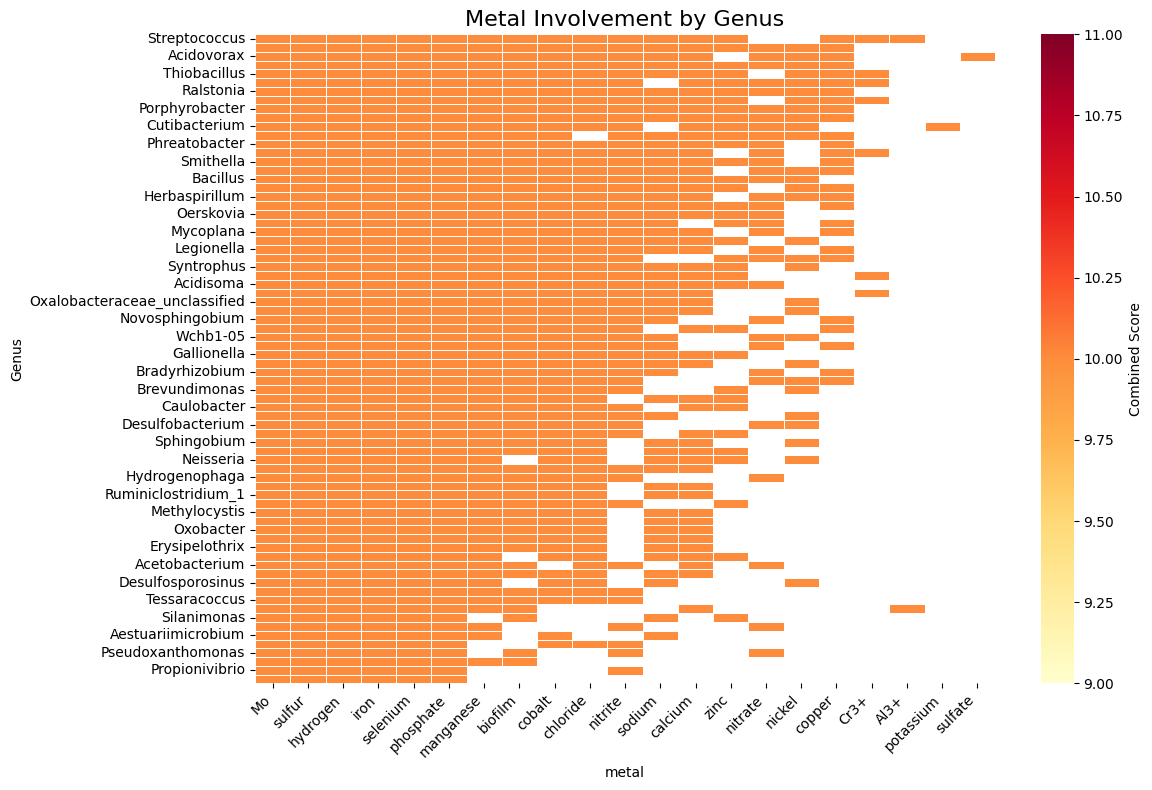

In [ ]:
def plot_metal_involvement(prioritized_markers):
    """
    Creates a heatmap showing metal involvement by genus across risk categories,
    using the actual metal names from the data.
    """
    # Process metal involvement data
    metal_data = []

    for _, row in prioritized_markers.iterrows():
        if isinstance(row['metals_involved'], str) and row['metals_involved']:
            # Use the correct delimiter based on the data format (comma or semicolon)
            metals = [m.strip() for m in row['metals_involved'].split(';')]
            for metal in metals:
                metal_data.append({
                    'Genus': row['Genus'],
                    'metal': metal,  # Keep the original metal name
                    'Category 1': row['mean_cat1'],
                    'Category 2': row['mean_cat2'],
                    'Category 3': row['mean_cat3'],
                    'combined_score': row['combined_score']
                })

    # Convert to DataFrame
    metal_df = pd.DataFrame(metal_data)

    # Group by genus and metal
    grouped = metal_df.groupby(['Genus', 'metal']).agg({
        'Category 1': 'mean',
        'Category 2': 'mean',
        'Category 3': 'mean',
        'combined_score': 'mean'
    }).reset_index()

    # Create a pivot table for the heatmap
    pivot = grouped.pivot_table(
        index='Genus',
        columns='metal',
        values='combined_score',
        aggfunc='mean'
    ).fillna(0)

    # Sort by sum of values
    pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
    pivot = pivot[pivot.sum().sort_values(ascending=False).index]

    # Set up the plot
    plt.figure(figsize=(12, 8))

    # Create heatmap - using a mask for zero values to make them white
    mask = pivot == 0
    sns.heatmap(
        pivot,
        cmap='YlOrRd',
        linewidths=0.5,
        cbar_kws={'label': 'Combined Score'},
        mask=mask
    )

    plt.title('Metal Involvement by Genus', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    # Print a simple dictionary of the metals for reference
    #metal_list = sorted(metal_df['metal'].unique())

    return plt.gcf()
plot_metal_involvement(high_mechanism_relevance)
plt.tight_layout()

https://www.youtube.com/watch?v=jQVNsyAnDMo

https://microreact.org/



# 7. Organic Matter Validation
## 7.1 CORRELATING PROTEIN PRESENCE WITH OM REPRESENTATION (OX_AC)
This step tests whether the chosen OM surrogates influence protein expression patterns. The acetate and oxalate concentrations are treated as physicochemical features and see the correlation with: protein frequency, functional category scores, overall combined score. This allows to evaluate whether acetate or oxalate-rich environments are associated with higher-scoring proteins or specific functional groups.
I have a big gap on the cation anion account and then used mackensy, [2012] method from the usgs to check Ec measured Vs calculated and cation Vs ions. It is a big gap still, but I have a lot of OM so I could no assume as normally that OM is CH4 so I attribute it to small organic acids and put acetate and oxalate as OM representatives, I have a small study of small acids form on failure analysis and also report of a mass that has a magnetic consistency, so I infere that those muss be some organic metalic compound but only accounted for AC- and Ox-2, I thought better to chose this other compounds Fe rich but I don't know how to do it actually. So in my bacteria I actually found lots of them with Ac- metabolism whiles I was looking at the families I realise no only oxobacter accendants, but others similar, also got important biofilm formers, there is also halogen related and should be, big deal of difference make the material and location cause water treatment, unfortunately the annotations are no to be taken as parameters but can serve as annotations. This part would validate assumptions about:

Organic acid presence (by showing metabolic capability)
Metal-organic complex formation (through siderophore and metal-binding pathways)
Biofilm formation potential (which can influence local chemistry)

Validate acetate/oxalate assumptions by showing if these metabolic pathways are actually present
Look for other potential organic acid pathways might want to consider
Identify metal-organic interaction pathways that could explain magnetic mass observation

In [ ]:
# Merge metadata with protein scoring on similar column
merged = results.merge(env_data[['sample_id', 'acetate_conc', 'oxalate_conc']], on='sample_id', how='left')

# OPTIONAL: Correlation matrix (for numerical analysis)
correlation_matrix = merged[['combined_score', 'functional_mechanisms_score', 'acetate_conc', 'oxalate_conc']].corr()
print("Correlation matrix:\n", correlation_matrix)

sns.lmplot(data=merged, x='acetate_conc', y='functional_mechanisms_score', hue='corrosion_relevance')
plt.title("Acetate vs Functional Score by Corrosion Relevance")
plt.show()


In [ ]:
def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],

        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],

        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],

        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }

    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    pathway_data = {}
    pathway_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]

            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)

    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in pathway_data.items()
    })

    # Calculate correlations
    correlations = category_means.corr()

    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='relative_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

# calling the function
pathway_data, pathway_stats = analyze_organic_metal_pathways(Picrust_Result)category_means, correlations, high_corr = analyze_pathway_relationships(pathway_data)
plot_pathway_analysis(pathway_stats, pathway_data)